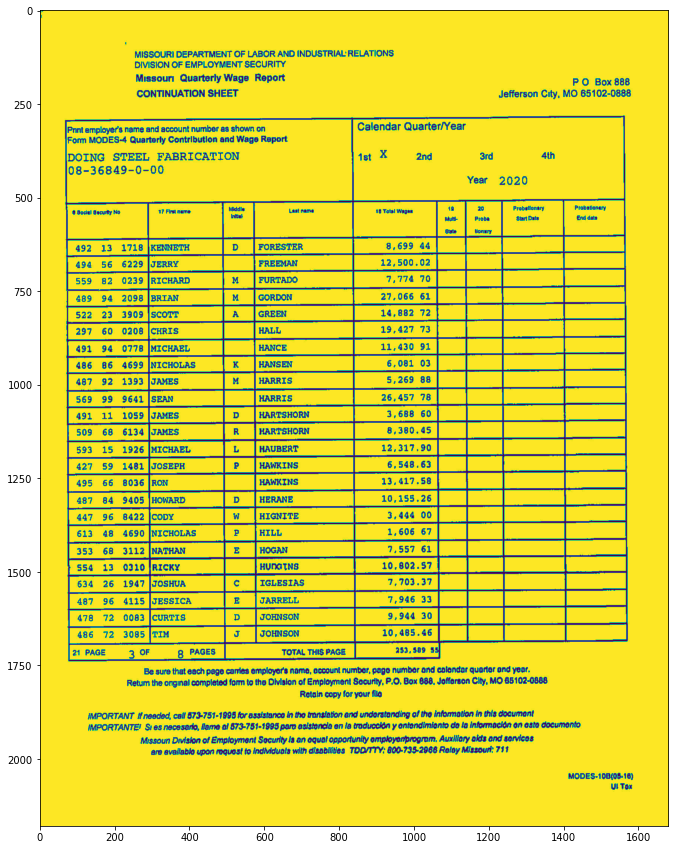

In [56]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
  
# Read Images
img = mpimg.imread('/home/vimal/Documents/table_detect_samples/structured images/input/in/0836849000.jpeg')

plt.figure(figsize=(15,15))
# Output Images
plt.imshow(img)

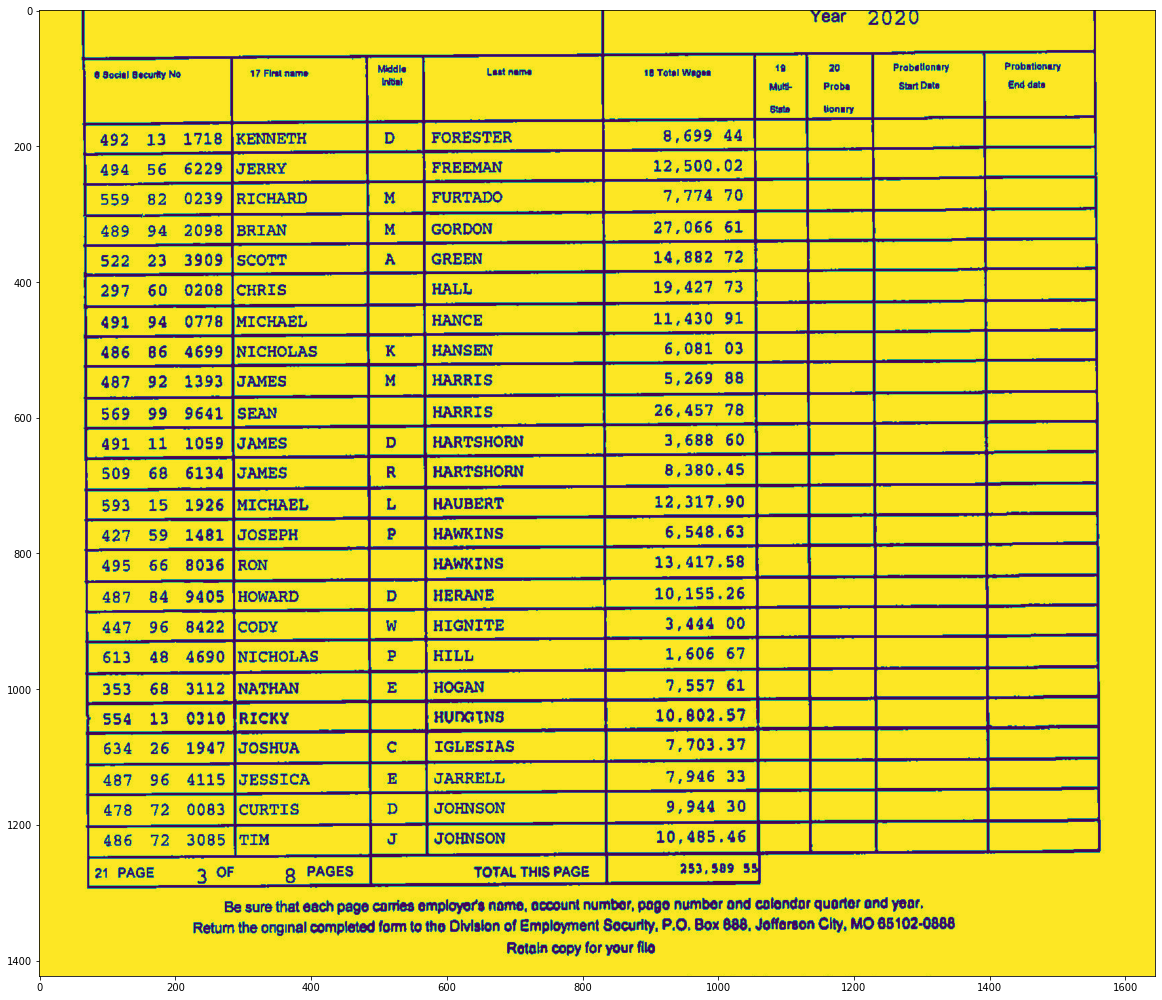

In [57]:
from PIL import Image
import cv2
  
# Opens a image in RGB mode
im = Image.open(r"/home/vimal/Documents/table_detect_samples/structured images/input/in/0836849000.jpeg")
#im =cv2.imread('/home/vimal/Documents/table_detect_samples/pre/0347682000.jpeg')
# Size of the image in pixels (size of orginal image)
# (This is not mandatory)
width, height = im.size
  
# Setting the points for cropped image
left = 5
top = height /4.9
right = 1650
bottom = 3 * height / 3.5
  
# Cropped image of above dimension
# (It will not change orginal image)
im1 = im.crop((left, top, right, bottom))
plt.figure(figsize=(20,20))
plt.imshow(im1)
im1.save('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images/0836849000_crop.jpeg')
# Shows the image in image viewer

In [58]:
import cv2
import os

def extract_cell_images_from_table(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
    )
    
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.05 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    
    # Filter out contours that aren't rectangular. Those that aren't rectangular
    # are probably noise.
    approx_rects = [p for p in approx_polys if len(p) == 4]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]
    
    # Filter out rectangles that are too narrow or too short.
    MIN_RECT_WIDTH = 40
    MIN_RECT_HEIGHT = 10
    bounding_rects = [
        r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
    ]
    
    # The largest bounding rectangle is assumed to be the entire table.
    # Remove it from the list. We don't want to accidentally try to OCR
    # the entire table.
    largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
    bounding_rects = [b for b in bounding_rects if b is not largest_rect]
    
    cells = [c for c in bounding_rects]
    def cell_in_same_row(c1, c2):
        c1_center = c1[1] + c1[3] - c1[3] / 2
        c2_bottom = c2[1] + c2[3]
        c2_top = c2[1]
        return c2_top < c1_center < c2_bottom
    
    orig_cells = [c for c in cells]
    rows = []
    while cells:
        first = cells[0]
        rest = cells[1:]
        cells_in_same_row = sorted(
            [
                c for c in rest
                if cell_in_same_row(c, first)
            ],
            key=lambda c: c[0]
        )
    
        row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
        rows.append(row_cells)
        cells = [
            c for c in rest
            if not cell_in_same_row(c, first)
        ]
    
    # Sort rows by average height of their center.
    def avg_height_of_center(row):
        centers = [y + h - h / 2 for x, y, w, h in row]
        return sum(centers) / len(centers)
    
    rows.sort(key=avg_height_of_center)
    cell_images_rows = []
    for row in rows:
        cell_images_row = []
        for x, y, w, h in row:
            cell_images_row.append(image[y:y+h, x:x+w])
        cell_images_rows.append(cell_images_row)
    return cell_images_rows

def main(f):
    results = []
    directory, filename = os.path.split(f)
    table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    rows = extract_cell_images_from_table(table)
    cell_img_dir = os.path.join(directory, "cells")
    os.makedirs(cell_img_dir, exist_ok=True)
    out_path = '/home/vimal/Documents/table_detect_samples/structured images/input/0836849000/cells'
    paths = []
    for i, row in enumerate(rows):
        for j, cell in enumerate(row):
            cell_filename = "{:03d}-{:03d}.png".format(i, j)
            path = os.path.join(out_path, cell_filename)
            cv2.imwrite(path, cell)
            paths.append(path)
    return paths

f = '/home/vimal/Documents/table_detect_samples/structured images/input/crop_images/0836849000_crop.jpeg'

main(f)

['/home/vimal/Documents/table_detect_samples/structured images/input/0836849000/cells/000-000.png',
 '/home/vimal/Documents/table_detect_samples/structured images/input/0836849000/cells/000-001.png',
 '/home/vimal/Documents/table_detect_samples/structured images/input/0836849000/cells/000-002.png',
 '/home/vimal/Documents/table_detect_samples/structured images/input/0836849000/cells/000-003.png',
 '/home/vimal/Documents/table_detect_samples/structured images/input/0836849000/cells/000-004.png',
 '/home/vimal/Documents/table_detect_samples/structured images/input/0836849000/cells/000-005.png',
 '/home/vimal/Documents/table_detect_samples/structured images/input/0836849000/cells/000-006.png',
 '/home/vimal/Documents/table_detect_samples/structured images/input/0836849000/cells/000-007.png',
 '/home/vimal/Documents/table_detect_samples/structured images/input/0836849000/cells/000-008.png',
 '/home/vimal/Documents/table_detect_samples/structured images/input/0836849000/cells/001-000.png',


In [59]:
import math
import os
import sys

import cv2
import numpy as np
import pytesseract

def main(image_file, tess_args):
    """
    OCR the image and output the text to a file with an extension that is ready
    to be used in Tesseract training (.gt.txt).
    Tries to crop the image so that only the relevant text gets passed to Tesseract.
    Returns the name of the text file that contains the text.
    """
    #file_path = '/home/vimal/Documents/table_detect_samples/structured images/input/011364700/cells'
    #image_file = os.listdir(file_path)
    
    for f in image_file:
        #print(f)
        directory, filename = os.path.split(f)
        filename_sans_ext, ext = os.path.splitext(filename)
        image = cv2.imread(os.path.join(file_path,f), cv2.IMREAD_GRAYSCALE)
        cropped = crop_to_text(image)
        #ocr_data_dir = os.path.join(directory, "ocr_data")
        #os.makedirs(ocr_data_dir, exist_ok=True)
        #out_imagepath = os.path.join(ocr_data_dir, filename)
        out_path = '/home/vimal/Documents/table_detect_samples/structured images/input/0836849000/text'
        out_txtpath = os.path.join(out_path, "{}.gt.txt".format(filename_sans_ext))
        #cv2.imwrite(out_imagepath, cropped)
        if not tess_args:
            d = os.path.dirname(sys.modules["table_ocr"].__file__)
            tessdata_dir = os.path.join(d, "tessdata")
            tess_args = ["--psm", "7", "-l", "table-ocr", "--tessdata-dir", tessdata_dir]
        txt = ocr_image(cropped, " ".join(tess_args))
        with open(out_txtpath, "w") as txt_file:
            txt_file.write(txt)
        #return out_txtpath
def crop_to_text(image):
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2

    img_bin = cv2.adaptiveThreshold(
        ~image,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )

    img_h, img_w = image.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img_w * 0.5), 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(img_h * 0.7)))
    horizontal_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    both = horizontal_lines + vertical_lines
    cleaned = img_bin - both

    # Get rid of little noise.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)
    opened = cv2.dilate(opened, kernel)

    contours, hierarchy = cv2.findContours(opened, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    bounding_rects = [cv2.boundingRect(c) for c in contours]
    NUM_PX_COMMA = 6
    MIN_CHAR_AREA = 5 * 9
    char_sized_bounding_rects = [(x, y, w, h) for x, y, w, h in bounding_rects if w * h > MIN_CHAR_AREA]
    if char_sized_bounding_rects:
        minx, miny, maxx, maxy = math.inf, math.inf, 0, 0
        for x, y, w, h in char_sized_bounding_rects:
            minx = min(minx, x)
            miny = min(miny, y)
            maxx = max(maxx, x + w)
            maxy = max(maxy, y + h)
        x, y, w, h = minx, miny, maxx - minx, maxy - miny
        cropped = image[y:min(img_h, y+h+NUM_PX_COMMA), x:min(img_w, x+w)]
    else:
        # If we morphed out all of the text, assume an empty image.
        cropped = MAX_COLOR_VAL * np.ones(shape=(20, 100), dtype=np.uint8)
    bordered = cv2.copyMakeBorder(cropped, 5, 5, 5, 5, cv2.BORDER_CONSTANT, None, 255)
    return bordered
def ocr_image(image, config):
    return pytesseract.image_to_string(
        image,
        config=config
    )

file_path = '/home/vimal/Documents/table_detect_samples/structured images/input/0836849000/cells'
image_file = os.listdir(file_path)
tess_args = os.listdir(file_path)

main(image_file, tess_args)


In [60]:
import io 
import csv

def text_files_to_csv(files):
    """Files must be sorted lexicographically
    Filenames must be <row>-<colum>.txt.
    000-000.txt
    000-001.txt
    001-000.txt
    etc...
    """
    rows = []
    for f in files:
        directory, filename = os.path.split(f)
        with open(os.path.join(file_path,f)) as of:
            txt = of.read().strip()
        row, column = map(int, filename.split(".")[0].split("-"))
        if row == len(rows):
            rows.append([])
        rows[row].append(txt)

    csv_file = io.StringIO()
    writer = csv.writer(csv_file)
    writer.writerows(rows)
    return csv_file.getvalue()

def main(files):
    return text_files_to_csv(files)


file_path = '/home/vimal/Documents/table_detect_samples/structured images/input/0836849000/text'
file = file = os.listdir(file_path)
files = sorted(file)


a = main(files)
#print(a)


text_file = open("/home/vimal/Documents/table_detect_samples/structured images/input/0836849000/text_file/0836849000_text.txt", "wt")
n = text_file.write(a)
text_file.close()


import pandas as pd

df = pd.read_csv('/home/vimal/Documents/table_detect_samples/structured images/input/0836849000/text_file/0836849000_text.txt',header=None)
#df = df.dropna(how='all', axis=1)
df.columns = df.iloc[0]
df = df[1:]
df.to_csv('/home/vimal/Documents/table_detect_samples/structured images/input/0836849000/csv/0836849000_xl.csv', 
                  index = None)
df

0    @ Social Becunty No   17 First name: Middle\nntval        NaN  \
1            492 13 1718          KENNETH           NaN   FORESTER   
2            494 56 6229            JERRY           NaN    FREEMAN   
3            559 82 0239          RICHARD           NaN    FURTADO   
4            489 94 2098            BRIAN           NaN     GORDON   
5            522 23 3909            scoTT           NaN      GREEN   
6            297 60 0208            CHRIS           NaN        NaN   
7            491 94 0778          MICHAEL           NaN      HANCE   
8            486 86 4699         NICHOLAS           NaN     HANSEN   
9            487 92 1393            JAMES           NaN     HARRIS   
10           569 99 9641              NaN           NaN     HARRIS   
11           491 11 1059            JAMES           NaN  HARTSHORN   
12           509 68 6134            JAMES           NaN  HARTSHORN   
13           593 15 1926          MICHAEL           NaN    HAUBERT   
14           427 59 1481           JOSEPH           NaN    HAWKINS   
15           495 66 8036              RON           NaN    HAWKINS   
16           487 84 9405           HOWARD           NaN     HERANE   
17           447 96 8422             CODY           NaN    HIGNITE   
18           613 48 4690         NICHOLAS           NaN       HILL   
19           353 68 3112           NATHAN           NaN        NaN   
20           $54 13 0210            RICKY           NaN    HUDGINS   
21           634 26 1947           JOSHUA           NaN   IGLESIAS   
22           487 96 4115          JESSICA           NaN    JARRELL   
23           478 72 0083           CURTIS           NaN    JOHNSON   
24           486 72 3085              TIM           NaN    JOHNSON   
25  21 PAGE 3 OF Q PAGES  TOTAL THIS PAGE    253,989 $5        NaN   

0  18 Total Wagea 18\nMutt 20\nProbe\n\nonary Probatlona\nStart Dat  \
1        8,699 44      NaN                NaN                   NaN   
2       12,500.02      NaN                NaN                   NaN   
3        7,774 70      NaN                NaN                   NaN   
4       27,066 61      NaN                NaN                   NaN   
5       14,882 72      NaN                NaN                   NaN   
6       19,427 73      NaN                NaN                   NaN   
7       11,430 91      NaN                NaN                   NaN   
8        6,081 03      NaN                NaN                   NaN   
9        5,269 98      NaN                NaN                   NaN   
10      26,457 78      NaN                NaN                   NaN   
11       3,688 60      NaN                NaN                   NaN   
12       8,380.45      NaN                NaN                   NaN   
13      12,317.90      NaN                NaN                   NaN   
14       6,548.63      NaN                NaN                   NaN   
15      13,417.58      NaN                NaN                   NaN   
16      10,155.26      NaN                NaN                   NaN   
17       3,444 00      NaN                NaN                   NaN   
18       1,606 67      NaN                NaN                   NaN   
19       7,557 61      NaN                NaN                   NaN   
20      10,802.57      NaN                NaN                   NaN   
21       7,703.37      NaN                NaN                   NaN   
22       7,946 33      NaN                NaN                   NaN   
23       9,944 30      NaN                NaN                   NaN   
24      10,485.46      NaN                NaN                   NaN   
25            NaN      NaN                NaN                   NaN   

0  Probationary\nEnd date  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  
5                     NaN  
6                     NaN  
7                     NaN  
8                     NaN  
9                     NaN  
10                    NaN  
11                    Na

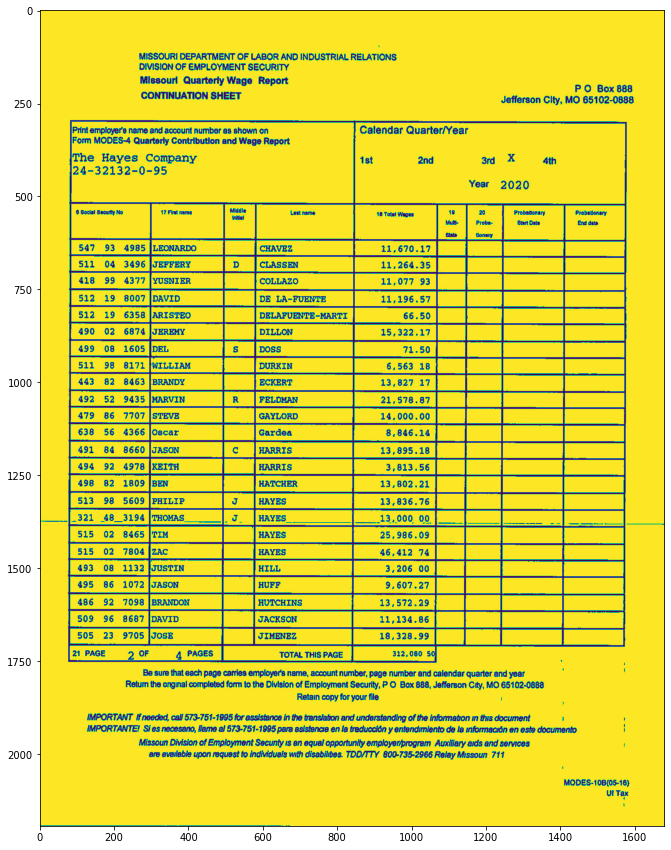

In [83]:
p = '0108704000.jpeg'

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
  
# Read Images
#img = mpimg.imread('/home/vimal/Documents/table_detect_samples/structured images/input/in/0836849000.jpeg')
img = mpimg.imread(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/in',p))
plt.figure(figsize=(15,15))
# Output Images
plt.imshow(img)

In [84]:
os.path.splitext(p)[0]

'0108704000'

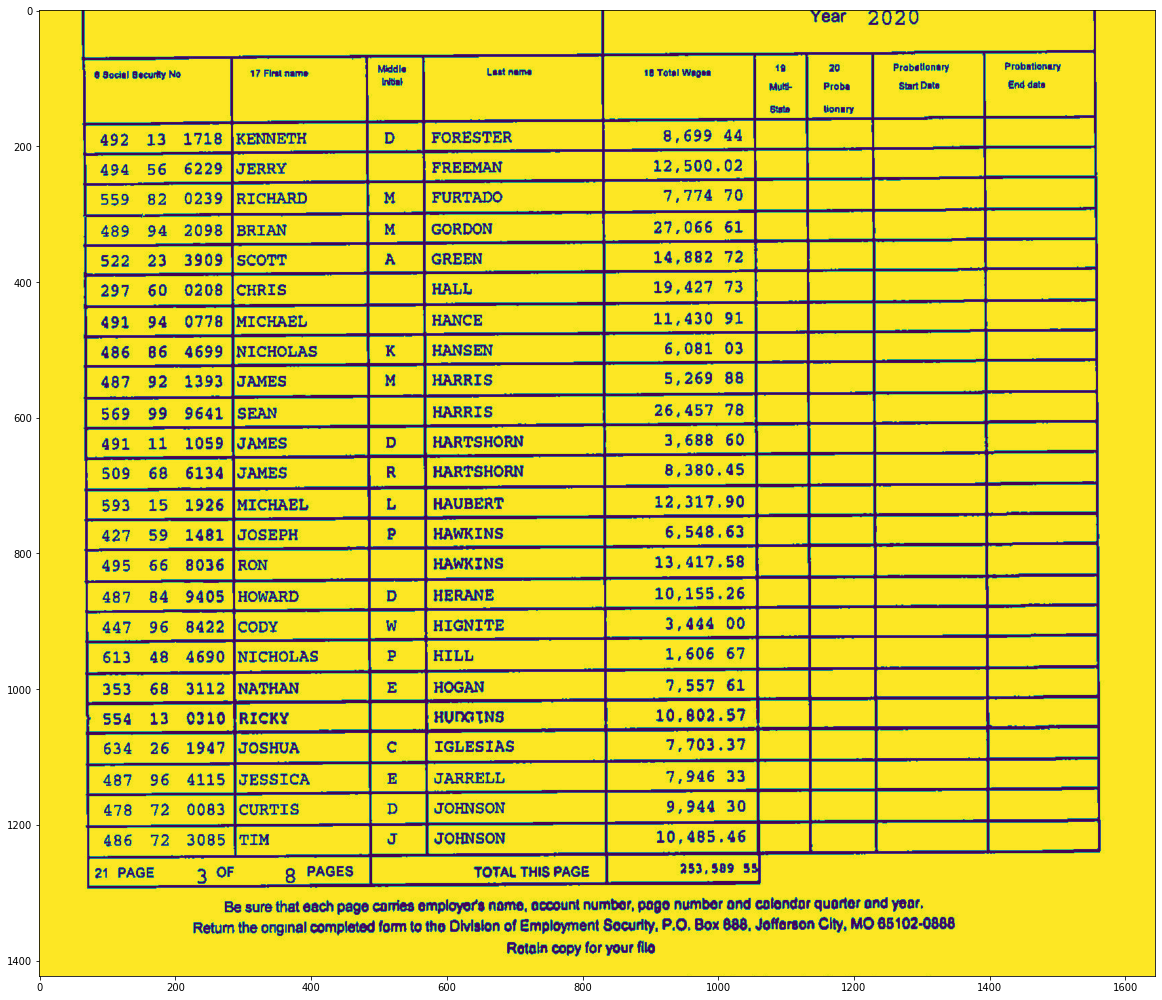

In [85]:
from PIL import Image
import cv2
  
# Opens a image in RGB mode
#im = Image.open(r"/home/vimal/Documents/table_detect_samples/structured images/input/in",p)
img = mpimg.imread(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/in',p))

#im =cv2.imread('/home/vimal/Documents/table_detect_samples/pre/0347682000.jpeg')
# Size of the image in pixels (size of orginal image)
# (This is not mandatory)
width, height = im.size
  
# Setting the points for cropped image
left = 5
top = height /4.9
right = 1650
bottom = 3 * height / 3.5
  
# Cropped image of above dimension
# (It will not change orginal image)
im1 = im.crop((left, top, right, bottom))
plt.figure(figsize=(20,20))
plt.imshow(im1)
#im1.save('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images/0836849000_crop.jpeg')
#im1.save('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images/0836849000_crop.jpeg')
b = os.path.splitext(p)[0]+'_crop.jpeg'
im1.save(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test/crop_images',b))
# Shows the image in image viewer

In [86]:
import cv2
import os

def extract_cell_images_from_table(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
    )
    
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.05 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    
    # Filter out contours that aren't rectangular. Those that aren't rectangular
    # are probably noise.
    approx_rects = [p for p in approx_polys if len(p) == 4]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]
    
    # Filter out rectangles that are too narrow or too short.
    MIN_RECT_WIDTH = 40
    MIN_RECT_HEIGHT = 10
    bounding_rects = [
        r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
    ]
    
    # The largest bounding rectangle is assumed to be the entire table.
    # Remove it from the list. We don't want to accidentally try to OCR
    # the entire table.
    largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
    bounding_rects = [b for b in bounding_rects if b is not largest_rect]
    
    cells = [c for c in bounding_rects]
    def cell_in_same_row(c1, c2):
        c1_center = c1[1] + c1[3] - c1[3] / 2
        c2_bottom = c2[1] + c2[3]
        c2_top = c2[1]
        return c2_top < c1_center < c2_bottom
    
    orig_cells = [c for c in cells]
    rows = []
    while cells:
        first = cells[0]
        rest = cells[1:]
        cells_in_same_row = sorted(
            [
                c for c in rest
                if cell_in_same_row(c, first)
            ],
            key=lambda c: c[0]
        )
    
        row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
        rows.append(row_cells)
        cells = [
            c for c in rest
            if not cell_in_same_row(c, first)
        ]
    
    # Sort rows by average height of their center.
    def avg_height_of_center(row):
        centers = [y + h - h / 2 for x, y, w, h in row]
        return sum(centers) / len(centers)
    
    rows.sort(key=avg_height_of_center)
    cell_images_rows = []
    for row in rows:
        cell_images_row = []
        for x, y, w, h in row:
            cell_images_row.append(image[y:y+h, x:x+w])
        cell_images_rows.append(cell_images_row)
    return cell_images_rows

def main(f):
    results = []
    directory, filename = os.path.split(f)
    table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    rows = extract_cell_images_from_table(table)
    cell_img_dir = os.path.join(directory, "cells")
    os.makedirs(cell_img_dir, exist_ok=True)
    out_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test',
                            os.path.splitext(p)[0],'cells')
    paths = []
    for i, row in enumerate(rows):
        for j, cell in enumerate(row):
            cell_filename = "{:03d}-{:03d}.png".format(i, j)
            path = os.path.join(out_path, cell_filename)
            cv2.imwrite(path, cell)
            paths.append(path)
    return paths

f = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test/crop_images',b)

main(f)

['/home/vimal/Documents/table_detect_samples/structured images/test/0108704000/cells/000-000.png',
 '/home/vimal/Documents/table_detect_samples/structured images/test/0108704000/cells/000-001.png',
 '/home/vimal/Documents/table_detect_samples/structured images/test/0108704000/cells/000-002.png',
 '/home/vimal/Documents/table_detect_samples/structured images/test/0108704000/cells/000-003.png',
 '/home/vimal/Documents/table_detect_samples/structured images/test/0108704000/cells/000-004.png',
 '/home/vimal/Documents/table_detect_samples/structured images/test/0108704000/cells/000-005.png',
 '/home/vimal/Documents/table_detect_samples/structured images/test/0108704000/cells/000-006.png',
 '/home/vimal/Documents/table_detect_samples/structured images/test/0108704000/cells/000-007.png',
 '/home/vimal/Documents/table_detect_samples/structured images/test/0108704000/cells/000-008.png',
 '/home/vimal/Documents/table_detect_samples/structured images/test/0108704000/cells/001-000.png',
 '/home/vi

In [87]:
f = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test/crop_images',b)
print(f)

/home/vimal/Documents/table_detect_samples/structured images/test/crop_images/0108704000_crop.jpeg


In [88]:
out_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test',os.path.splitext(p)[0],'cells')
print(out_path)

/home/vimal/Documents/table_detect_samples/structured images/test/0108704000/cells


In [89]:
import math
import os
import sys

import cv2
import numpy as np
import pytesseract

def main(image_file, tess_args):
    """
    OCR the image and output the text to a file with an extension that is ready
    to be used in Tesseract training (.gt.txt).
    Tries to crop the image so that only the relevant text gets passed to Tesseract.
    Returns the name of the text file that contains the text.
    """
    #file_path = '/home/vimal/Documents/table_detect_samples/structured images/input/011364700/cells'
    #image_file = os.listdir(file_path)
    
    for f in image_file:
        #print(f)
        directory, filename = os.path.split(f)
        filename_sans_ext, ext = os.path.splitext(filename)
        image = cv2.imread(os.path.join(file_path,f), cv2.IMREAD_GRAYSCALE)
        cropped = crop_to_text(image)
        #ocr_data_dir = os.path.join(directory, "ocr_data")
        #os.makedirs(ocr_data_dir, exist_ok=True)
        #out_imagepath = os.path.join(ocr_data_dir, filename)
        out_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test',
                            os.path.splitext(p)[0],'text')
        out_txtpath = os.path.join(out_path, "{}.gt.txt".format(filename_sans_ext))
        #cv2.imwrite(out_imagepath, cropped)
        if not tess_args:
            d = os.path.dirname(sys.modules["table_ocr"].__file__)
            tessdata_dir = os.path.join(d, "tessdata")
            tess_args = ["--psm", "7", "-l", "table-ocr", "--tessdata-dir", tessdata_dir]
        txt = ocr_image(cropped, " ".join(tess_args))
        with open(out_txtpath, "w") as txt_file:
            txt_file.write(txt)
        #return out_txtpath
def crop_to_text(image):
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2

    img_bin = cv2.adaptiveThreshold(
        ~image,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )

    img_h, img_w = image.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img_w * 0.5), 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(img_h * 0.7)))
    horizontal_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    both = horizontal_lines + vertical_lines
    cleaned = img_bin - both

    # Get rid of little noise.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)
    opened = cv2.dilate(opened, kernel)

    contours, hierarchy = cv2.findContours(opened, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    bounding_rects = [cv2.boundingRect(c) for c in contours]
    NUM_PX_COMMA = 6
    MIN_CHAR_AREA = 5 * 9
    char_sized_bounding_rects = [(x, y, w, h) for x, y, w, h in bounding_rects if w * h > MIN_CHAR_AREA]
    if char_sized_bounding_rects:
        minx, miny, maxx, maxy = math.inf, math.inf, 0, 0
        for x, y, w, h in char_sized_bounding_rects:
            minx = min(minx, x)
            miny = min(miny, y)
            maxx = max(maxx, x + w)
            maxy = max(maxy, y + h)
        x, y, w, h = minx, miny, maxx - minx, maxy - miny
        cropped = image[y:min(img_h, y+h+NUM_PX_COMMA), x:min(img_w, x+w)]
    else:
        # If we morphed out all of the text, assume an empty image.
        cropped = MAX_COLOR_VAL * np.ones(shape=(20, 100), dtype=np.uint8)
    bordered = cv2.copyMakeBorder(cropped, 5, 5, 5, 5, cv2.BORDER_CONSTANT, None, 255)
    return bordered
def ocr_image(image, config):
    return pytesseract.image_to_string(
        image,
        config=config
    )

file_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test',
                            os.path.splitext(p)[0],'cells')
image_file = os.listdir(file_path)
tess_args = os.listdir(file_path)

main(image_file, tess_args)


In [90]:
import io 
import csv

def text_files_to_csv(files):
    """Files must be sorted lexicographically
    Filenames must be <row>-<colum>.txt.
    000-000.txt
    000-001.txt
    001-000.txt
    etc...
    """
    rows = []
    for f in files:
        directory, filename = os.path.split(f)
        with open(os.path.join(file_path,f)) as of:
            txt = of.read().strip()
        row, column = map(int, filename.split(".")[0].split("-"))
        if row == len(rows):
            rows.append([])
        rows[row].append(txt)

    csv_file = io.StringIO()
    writer = csv.writer(csv_file)
    writer.writerows(rows)
    return csv_file.getvalue()

def main(files):
    return text_files_to_csv(files)


file_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test',
                            os.path.splitext(p)[0],'text')
file = file = os.listdir(file_path)
files = sorted(file)


a = main(files)
#print(a)

c = os.path.splitext(p)[0]+'_text.txt'
cs = os.path.splitext(p)[0]+'_xl.csv'



text_file = open(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test',
                            os.path.splitext(p)[0],'text_file',c), "wt")
n = text_file.write(a)
text_file.close()


import pandas as pd

df = pd.read_csv(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test',
                            os.path.splitext(p)[0],'text_file',c),header=None)
#df = df.dropna(how='all', axis=1)
df.columns = df.iloc[0]
df = df[1:]
df.to_csv(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test',
                            os.path.splitext(p)[0],'csv',cs), 
                  index = None)
df

0    @ Social Becunty No   17 First name: Middle\nntval        NaN  \
1            492 13 1718          KENNETH           NaN   FORESTER   
2            494 56 6229            JERRY           NaN    FREEMAN   
3            559 82 0239          RICHARD           NaN    FURTADO   
4            489 94 2098            BRIAN           NaN     GORDON   
5            522 23 3909            scoTT           NaN      GREEN   
6            297 60 0208            CHRIS           NaN        NaN   
7            491 94 0778          MICHAEL           NaN      HANCE   
8            486 86 4699         NICHOLAS           NaN     HANSEN   
9            487 92 1393            JAMES           NaN     HARRIS   
10           569 99 9641              NaN           NaN     HARRIS   
11           491 11 1059            JAMES           NaN  HARTSHORN   
12           509 68 6134            JAMES           NaN  HARTSHORN   
13           593 15 1926          MICHAEL           NaN    HAUBERT   
14           427 59 1481           JOSEPH           NaN    HAWKINS   
15           495 66 8036              RON           NaN    HAWKINS   
16           487 84 9405           HOWARD           NaN     HERANE   
17           447 96 8422             CODY           NaN    HIGNITE   
18           613 48 4690         NICHOLAS           NaN       HILL   
19           353 68 3112           NATHAN           NaN        NaN   
20           $54 13 0210            RICKY           NaN    HUDGINS   
21           634 26 1947           JOSHUA           NaN   IGLESIAS   
22           487 96 4115          JESSICA           NaN    JARRELL   
23           478 72 0083           CURTIS           NaN    JOHNSON   
24           486 72 3085              TIM           NaN    JOHNSON   
25  21 PAGE 3 OF Q PAGES  TOTAL THIS PAGE    253,989 $5        NaN   

0  18 Total Wagea 18\nMutt 20\nProbe\n\nonary Probatlona\nStart Dat  \
1        8,699 44      NaN                NaN                   NaN   
2       12,500.02      NaN                NaN                   NaN   
3        7,774 70      NaN                NaN                   NaN   
4       27,066 61      NaN                NaN                   NaN   
5       14,882 72      NaN                NaN                   NaN   
6       19,427 73      NaN                NaN                   NaN   
7       11,430 91      NaN                NaN                   NaN   
8        6,081 03      NaN                NaN                   NaN   
9        5,269 98      NaN                NaN                   NaN   
10      26,457 78      NaN                NaN                   NaN   
11       3,688 60      NaN                NaN                   NaN   
12       8,380.45      NaN                NaN                   NaN   
13      12,317.90      NaN                NaN                   NaN   
14       6,548.63      NaN                NaN                   NaN   
15      13,417.58      NaN                NaN                   NaN   
16      10,155.26      NaN                NaN                   NaN   
17       3,444 00      NaN                NaN                   NaN   
18       1,606 67      NaN                NaN                   NaN   
19       7,557 61      NaN                NaN                   NaN   
20      10,802.57      NaN                NaN                   NaN   
21       7,703.37      NaN                NaN                   NaN   
22       7,946 33      NaN                NaN                   NaN   
23       9,944 30      NaN                NaN                   NaN   
24      10,485.46      NaN                NaN                   NaN   
25            NaN      NaN                NaN                   NaN   

0  Probationary\nEnd date  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  
5                     NaN  
6                     NaN  
7                     NaN  
8                     NaN  
9                     NaN  
10                    NaN  
11                    Na

In [79]:
c = os.path.splitext(p)[0]+'_text.txt'

aa = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test',
                            os.path.splitext(p)[0],'text_file',c)
print(aa)

/home/vimal/Documents/table_detect_samples/structured images/test/0108704000/text_file/0108704000_text.txt


In [82]:
cs = os.path.splitext(p)[0]+'_xl.csv'

os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test',
                            os.path.splitext(p)[0],'csv',cs)

'/home/vimal/Documents/table_detect_samples/structured images/test/0108704000/csv/0108704000_xl.csv'

0    @ Social Becunty No   17 First name: Middle\nntval        NaN  \
1            492 13 1718          KENNETH           NaN   FORESTER   
2            494 56 6229            JERRY           NaN    FREEMAN   
3            559 82 0239          RICHARD           NaN    FURTADO   
4            489 94 2098            BRIAN           NaN     GORDON   
5            522 23 3909            scoTT           NaN      GREEN   
6            297 60 0208            CHRIS           NaN        NaN   
7            491 94 0778          MICHAEL           NaN      HANCE   
8            486 86 4699         NICHOLAS           NaN     HANSEN   
9            487 92 1393            JAMES           NaN     HARRIS   
10           569 99 9641              NaN           NaN     HARRIS   
11           491 11 1059            JAMES           NaN  HARTSHORN   
12           509 68 6134            JAMES           NaN  HARTSHORN   
13           593 15 1926          MICHAEL           NaN    HAUBERT   
14           427 59 1481           JOSEPH           NaN    HAWKINS   
15           495 66 8036              RON           NaN    HAWKINS   
16           487 84 9405           HOWARD           NaN     HERANE   
17           447 96 8422             CODY           NaN    HIGNITE   
18           613 48 4690         NICHOLAS           NaN       HILL   
19           353 68 3112           NATHAN           NaN        NaN   
20           $54 13 0210            RICKY           NaN    HUDGINS   
21           634 26 1947           JOSHUA           NaN   IGLESIAS   
22           487 96 4115          JESSICA           NaN    JARRELL   
23           478 72 0083           CURTIS           NaN    JOHNSON   
24           486 72 3085              TIM           NaN    JOHNSON   
25  21 PAGE 3 OF Q PAGES  TOTAL THIS PAGE    253,989 $5        NaN   

0  18 Total Wagea 18\nMutt 20\nProbe\n\nonary Probatlona\nStart Dat  \
1        8,699 44      NaN                NaN                   NaN   
2       12,500.02      NaN                NaN                   NaN   
3        7,774 70      NaN                NaN                   NaN   
4       27,066 61      NaN                NaN                   NaN   
5       14,882 72      NaN                NaN                   NaN   
6       19,427 73      NaN                NaN                   NaN   
7       11,430 91      NaN                NaN                   NaN   
8        6,081 03      NaN                NaN                   NaN   
9        5,269 98      NaN                NaN                   NaN   
10      26,457 78      NaN                NaN                   NaN   
11       3,688 60      NaN                NaN                   NaN   
12       8,380.45      NaN                NaN                   NaN   
13      12,317.90      NaN                NaN                   NaN   
14       6,548.63      NaN                NaN                   NaN   
15      13,417.58      NaN                NaN                   NaN   
16      10,155.26      NaN                NaN                   NaN   
17       3,444 00      NaN                NaN                   NaN   
18       1,606 67      NaN                NaN                   NaN   
19       7,557 61      NaN                NaN                   NaN   
20      10,802.57      NaN                NaN                   NaN   
21       7,703.37      NaN                NaN                   NaN   
22       7,946 33      NaN                NaN                   NaN   
23       9,944 30      NaN                NaN                   NaN   
24      10,485.46      NaN                NaN                   NaN   
25            NaN      NaN                NaN                   NaN   

0  Probationary\nEnd date  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  
5                     NaN  
6                     NaN  
7                     NaN  
8                     NaN  
9                     NaN  
10                    NaN  
11                    Na

<Figure size 1080x1080 with 0 Axes>

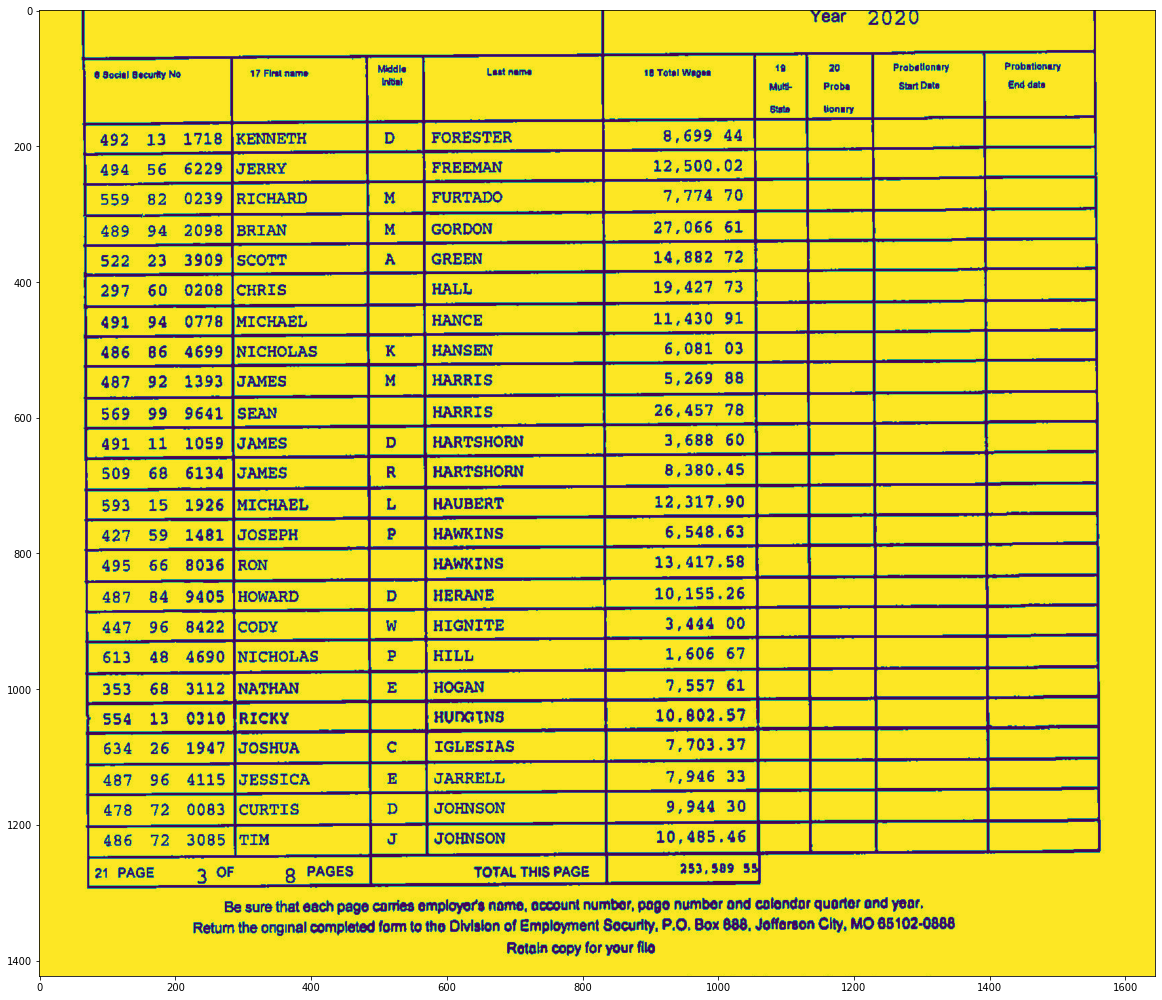

In [91]:
p = '0738815000.jpeg'

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
  
# Read Images
#img = mpimg.imread('/home/vimal/Documents/table_detect_samples/structured images/input/in/0836849000.jpeg')
img = mpimg.imread(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/in',p))
plt.figure(figsize=(15,15))
# Output Images
#plt.imshow(img)


from PIL import Image
import cv2
  
# Opens a image in RGB mode
#im = Image.open(r"/home/vimal/Documents/table_detect_samples/structured images/input/in",p)
#img = mpimg.imread(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/in',p))
im = Image.open(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/in',p))

#im =cv2.imread('/home/vimal/Documents/table_detect_samples/pre/0347682000.jpeg')
# Size of the image in pixels (size of orginal image)
# (This is not mandatory)
width, height = im.size
  
# Setting the points for cropped image
left = 5
top = height /4.9
right = 1650
bottom = 3 * height / 3.5
  
# Cropped image of above dimension
# (It will not change orginal image)
im1 = im.crop((left, top, right, bottom))
plt.figure(figsize=(20,20))
plt.imshow(im1)
#im1.save('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images/0836849000_crop.jpeg')
#im1.save('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images/0836849000_crop.jpeg')
b = os.path.splitext(p)[0]+'_crop.jpeg'
im1.save(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test/crop_images',b))
# Shows the image in image viewer

import cv2
import os

def extract_cell_images_from_table(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
    )
    
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.05 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    
    # Filter out contours that aren't rectangular. Those that aren't rectangular
    # are probably noise.
    approx_rects = [p for p in approx_polys if len(p) == 4]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]
    
    # Filter out rectangles that are too narrow or too short.
    MIN_RECT_WIDTH = 40
    MIN_RECT_HEIGHT = 10
    bounding_rects = [
        r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
    ]
    
    # The largest bounding rectangle is assumed to be the entire table.
    # Remove it from the list. We don't want to accidentally try to OCR
    # the entire table.
    largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
    bounding_rects = [b for b in bounding_rects if b is not largest_rect]
    
    cells = [c for c in bounding_rects]
    def cell_in_same_row(c1, c2):
        c1_center = c1[1] + c1[3] - c1[3] / 2
        c2_bottom = c2[1] + c2[3]
        c2_top = c2[1]
        return c2_top < c1_center < c2_bottom
    
    orig_cells = [c for c in cells]
    rows = []
    while cells:
        first = cells[0]
        rest = cells[1:]
        cells_in_same_row = sorted(
            [
                c for c in rest
                if cell_in_same_row(c, first)
            ],
            key=lambda c: c[0]
        )
    
        row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
        rows.append(row_cells)
        cells = [
            c for c in rest
            if not cell_in_same_row(c, first)
        ]
    
    # Sort rows by average height of their center.
    def avg_height_of_center(row):
        centers = [y + h - h / 2 for x, y, w, h in row]
        return sum(centers) / len(centers)
    
    rows.sort(key=avg_height_of_center)
    cell_images_rows = []
    for row in rows:
        cell_images_row = []
        for x, y, w, h in row:
            cell_images_row.append(image[y:y+h, x:x+w])
        cell_images_rows.append(cell_images_row)
    return cell_images_rows

def main(f):
    results = []
    directory, filename = os.path.split(f)
    table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    rows = extract_cell_images_from_table(table)
    cell_img_dir = os.path.join(directory, "cells")
    os.makedirs(cell_img_dir, exist_ok=True)
    out_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test',
                            os.path.splitext(p)[0],'cells')
    paths = []
    for i, row in enumerate(rows):
        for j, cell in enumerate(row):
            cell_filename = "{:03d}-{:03d}.png".format(i, j)
            path = os.path.join(out_path, cell_filename)
            cv2.imwrite(path, cell)
            paths.append(path)
    return paths

f = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test/crop_images',b)

main(f)

import math
import os
import sys

import cv2
import numpy as np
import pytesseract

def main(image_file, tess_args):
    """
    OCR the image and output the text to a file with an extension that is ready
    to be used in Tesseract training (.gt.txt).
    Tries to crop the image so that only the relevant text gets passed to Tesseract.
    Returns the name of the text file that contains the text.
    """
    #file_path = '/home/vimal/Documents/table_detect_samples/structured images/input/011364700/cells'
    #image_file = os.listdir(file_path)
    
    for f in image_file:
        #print(f)
        directory, filename = os.path.split(f)
        filename_sans_ext, ext = os.path.splitext(filename)
        image = cv2.imread(os.path.join(file_path,f), cv2.IMREAD_GRAYSCALE)
        cropped = crop_to_text(image)
        #ocr_data_dir = os.path.join(directory, "ocr_data")
        #os.makedirs(ocr_data_dir, exist_ok=True)
        #out_imagepath = os.path.join(ocr_data_dir, filename)
        out_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test',
                            os.path.splitext(p)[0],'text')
        out_txtpath = os.path.join(out_path, "{}.gt.txt".format(filename_sans_ext))
        #cv2.imwrite(out_imagepath, cropped)
        if not tess_args:
            d = os.path.dirname(sys.modules["table_ocr"].__file__)
            tessdata_dir = os.path.join(d, "tessdata")
            tess_args = ["--psm", "7", "-l", "table-ocr", "--tessdata-dir", tessdata_dir]
        txt = ocr_image(cropped, " ".join(tess_args))
        with open(out_txtpath, "w") as txt_file:
            txt_file.write(txt)
        #return out_txtpath
def crop_to_text(image):
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2

    img_bin = cv2.adaptiveThreshold(
        ~image,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )

    img_h, img_w = image.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img_w * 0.5), 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(img_h * 0.7)))
    horizontal_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    both = horizontal_lines + vertical_lines
    cleaned = img_bin - both

    # Get rid of little noise.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)
    opened = cv2.dilate(opened, kernel)

    contours, hierarchy = cv2.findContours(opened, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    bounding_rects = [cv2.boundingRect(c) for c in contours]
    NUM_PX_COMMA = 6
    MIN_CHAR_AREA = 5 * 9
    char_sized_bounding_rects = [(x, y, w, h) for x, y, w, h in bounding_rects if w * h > MIN_CHAR_AREA]
    if char_sized_bounding_rects:
        minx, miny, maxx, maxy = math.inf, math.inf, 0, 0
        for x, y, w, h in char_sized_bounding_rects:
            minx = min(minx, x)
            miny = min(miny, y)
            maxx = max(maxx, x + w)
            maxy = max(maxy, y + h)
        x, y, w, h = minx, miny, maxx - minx, maxy - miny
        cropped = image[y:min(img_h, y+h+NUM_PX_COMMA), x:min(img_w, x+w)]
    else:
        # If we morphed out all of the text, assume an empty image.
        cropped = MAX_COLOR_VAL * np.ones(shape=(20, 100), dtype=np.uint8)
    bordered = cv2.copyMakeBorder(cropped, 5, 5, 5, 5, cv2.BORDER_CONSTANT, None, 255)
    return bordered
def ocr_image(image, config):
    return pytesseract.image_to_string(
        image,
        config=config
    )

file_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test',
                            os.path.splitext(p)[0],'cells')
image_file = os.listdir(file_path)
tess_args = os.listdir(file_path)

main(image_file, tess_args)

import io 
import csv

def text_files_to_csv(files):
    """Files must be sorted lexicographically
    Filenames must be <row>-<colum>.txt.
    000-000.txt
    000-001.txt
    001-000.txt
    etc...
    """
    rows = []
    for f in files:
        directory, filename = os.path.split(f)
        with open(os.path.join(file_path,f)) as of:
            txt = of.read().strip()
        row, column = map(int, filename.split(".")[0].split("-"))
        if row == len(rows):
            rows.append([])
        rows[row].append(txt)

    csv_file = io.StringIO()
    writer = csv.writer(csv_file)
    writer.writerows(rows)
    return csv_file.getvalue()

def main(files):
    return text_files_to_csv(files)


file_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test',
                            os.path.splitext(p)[0],'text')
file = file = os.listdir(file_path)
files = sorted(file)


a = main(files)
#print(a)

c = os.path.splitext(p)[0]+'_text.txt'
cs = os.path.splitext(p)[0]+'_xl.csv'



text_file = open(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test',
                            os.path.splitext(p)[0],'text_file',c), "wt")
n = text_file.write(a)
text_file.close()


import pandas as pd

df = pd.read_csv(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test',
                            os.path.splitext(p)[0],'text_file',c),header=None)
#df = df.dropna(how='all', axis=1)
df.columns = df.iloc[0]
df = df[1:]
df.to_csv(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/test',
                            os.path.splitext(p)[0],'csv',cs), 
                  index = None)
df





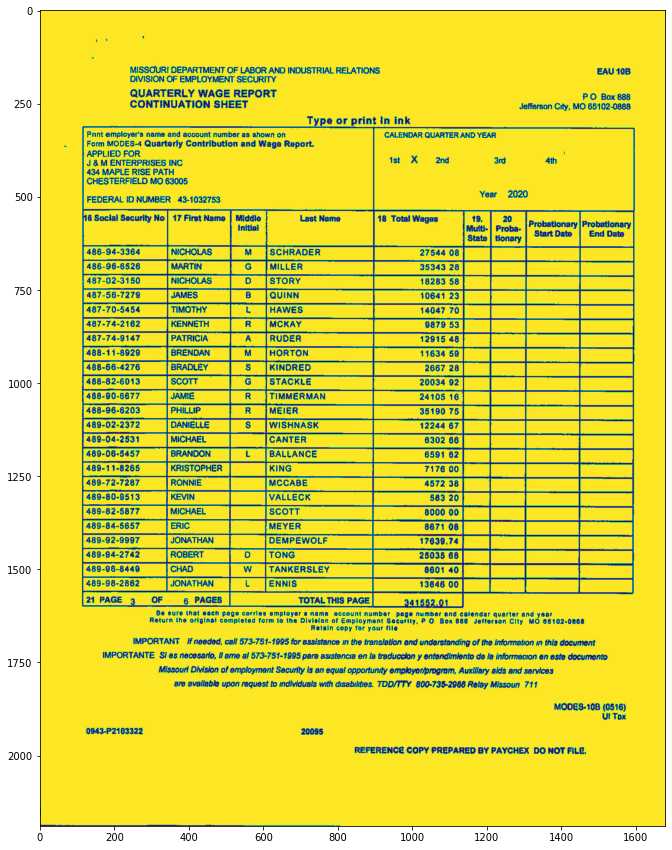

In [100]:
p = '0607248000.jpeg'

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
import math
import sys
import numpy as np
import pytesseract
import io 
import csv
import pandas as pd
import shutil, os

#shutil.copytree('/home/vimal/Documents/table_detect_samples/structured images/input/sample', 
                #os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                             #os.path.splitext(p)[0]))
  
# Read Images
#img = mpimg.imread('/home/vimal/Documents/table_detect_samples/structured images/input/in/0836849000.jpeg')
img = mpimg.imread(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/in',p))
plt.figure(figsize=(15,15))
# Output Images
plt.imshow(img)

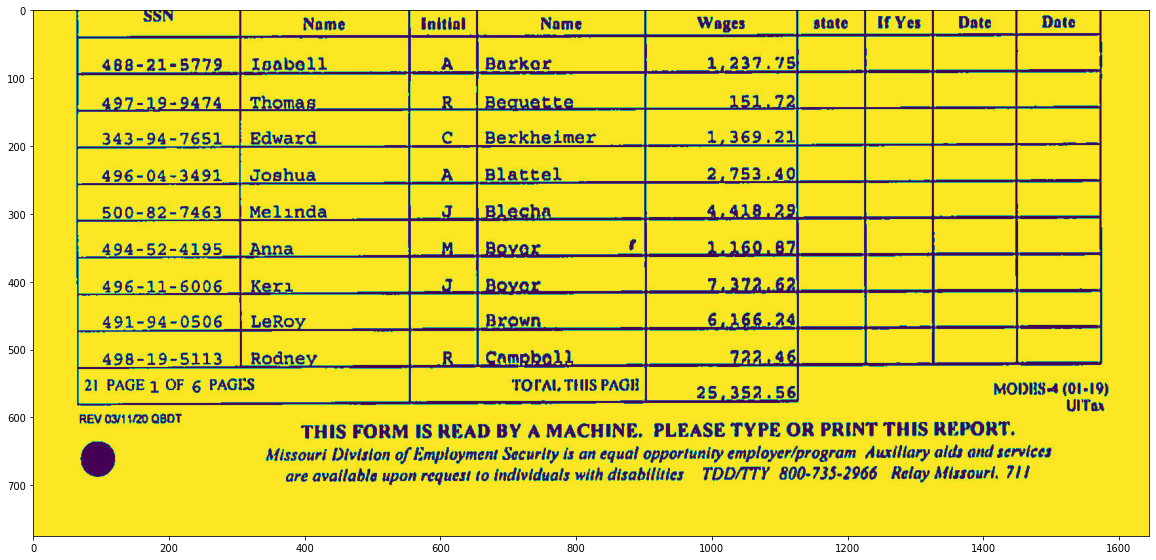

In [43]:
from PIL import Image
import cv2
  
# Opens a image in RGB mode
im = Image.open(r"/home/vimal/Documents/table_detect_samples/structured images/input/in/0113647000.jpeg")
#im =cv2.imread('/home/vimal/Documents/table_detect_samples/pre/0347682000.jpeg')
# Size of the image in pixels (size of orginal image)
# (This is not mandatory)
width, height = im.size
  
# Setting the points for cropped image
left = 5
top = height / 1.55
right = 1650
bottom = 3 * height / 3
  
# Cropped image of above dimension
# (It will not change orginal image)
im1 = im.crop((left, top, right, bottom))
plt.figure(figsize=(20,20))
plt.imshow(im1)
#im1.save('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images/0836849000_crop.jpeg')
# Shows the image in image viewer

0            16 Soc Sec No    17 Firat name Middle\nInitlal  ast name  \
1              492-66-3626            Shena             NaN     oftis   
2             496-068-6744          Abigail               c    Mactin   
3              497-94-6527           Amanda               J    Martin   
4              522-35-9077            Glain             NaN    Martin   
5              486-08-3114        Elizabeth               K   Maynard   
6              494-15-5292           Morgan             NaN    Miller   
7              495-06-2096    Jotfray Taler             NaN      Nash   
8              490-13-9546             Cody               R       Nea   
9             312-680-0458           Bronda              DB    PElaum   
10             493-19-0205            Gavin               D    Phelan   
11             493-82-1338            Carla               R     Platt   
12             499-11-5256          Rebecca               N     Prock   
13            499-680-7854           Shauna               D   Pueppke   
14             490-17-8221           Summer              Mw     Rilay   
15             493-96-6412             Abby               a  Rinehart   
16             487-11-7210           Krista               A      Roas   
17             488-92-0777         Marijean               o   Shipley   
18             493-15-3902         Samantha               &  Solasbee   
19             499-74-4041           Vineta               J   fitehia   
20             494-11-4139           Katrin               A    Taylor   
21             526-57-7999            Cindy               L    Thomas   
22             457-86-1680            Billy               J    Trivic   
23             498-78-1799           Angela             NaN   Wallace   
24             432-41-6595            Wilma               J    Wataon   
25  21 PAGE _3 OF _4 PAGES  TOTAL THIS PAGE      250,669.09       NaN   

0  18 Total Wages 19\nMult!\nState 20\nProba\ndonay Probationary\nStart Date  \
1       20,426 28              NaN              NaN                      NaN   
2       12,000 00              NaN              NaN                      NaN   
3       12,699 30              NaN              NaN                      NaN   
4       11,923 30              NaN              NaN                      NaN   
5        4,287 14              NaN              NaN                      NaN   
6        3,973 74              NaN              NaN                      NaN   
7       16,374 30              NaN              NaN                      NaN   
8        5,319_50              NaN              NaN                      NaN   
9        4,807 50              NaN              NaN                      NaN   
10       2,408 10              NaN              NaN                      NaN   
11       6,997 22              NaN              NaN                      NaN   
12       6,898 63              NaN              NaN                      NaN   
13       4,254 16              NaN              NaN                      NaN   
14       4,455 15              NaN              NaN                      NaN   
15      13,121 64              NaN              NaN                      NaN   
16         283 88              NaN              NaN                      NaN   
17      13,033 48              NaN              NaN                      NaN   
18       4,848 63              NaN              NaN                      NaN   
19      9,652,601              NaN              NaN                      NaN   
20         976 09              NaN              NaN                      NaN   
21       4,626 94              NaN              NaN                      NaN   
22      74,675 30              NaN              NaN                      NaN   
23       9,076 00              NaN              NaN                      NaN   
24       2,350.00              NaN              NaN                      NaN   
25            NaN              NaN              NaN                      NaN   

0  Probationary\nEnd

<Figure size 1080x1080 with 0 Axes>

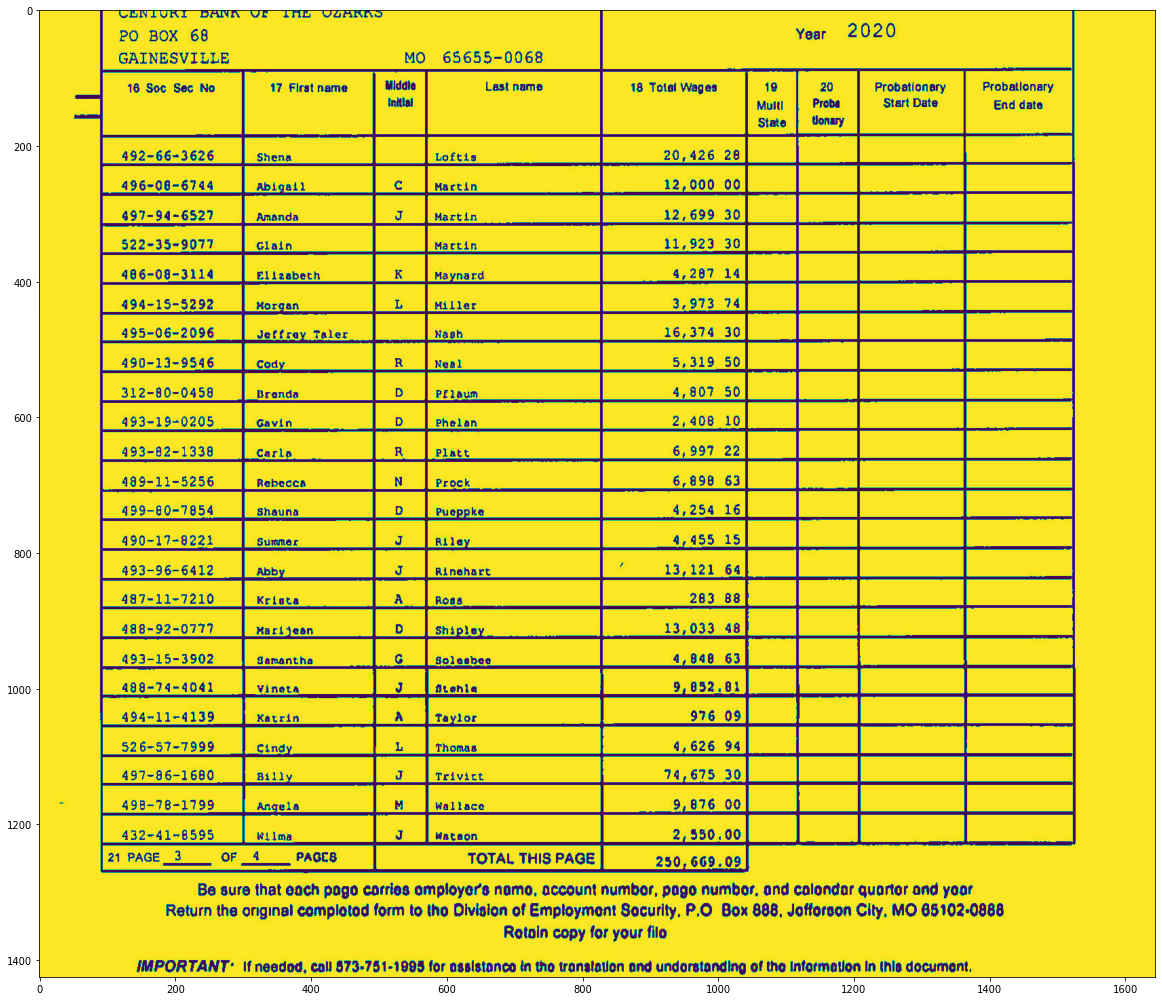

In [1]:
p = '0101439000.jpeg'

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
import math
import sys
import numpy as np
import pytesseract
import io 
import csv
import pandas as pd
import shutil, os

shutil.copytree('/home/vimal/Documents/table_detect_samples/structured images/input/sample', 
                os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                             os.path.splitext(p)[0]))
  
# Read Images
#img = mpimg.imread('/home/vimal/Documents/table_detect_samples/structured images/input/in/0836849000.jpeg')
img = mpimg.imread(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/in',p))
plt.figure(figsize=(15,15))
# Output Images
#plt.imshow(img)

# Opens a image in RGB mode
#im = Image.open(r"/home/vimal/Documents/table_detect_samples/structured images/input/in",p)
#img = mpimg.imread(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/in',p))
im = Image.open(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/in',p))

#im =cv2.imread('/home/vimal/Documents/table_detect_samples/pre/0347682000.jpeg')
# Size of the image in pixels (size of orginal image)
# (This is not mandatory)
width, height = im.size
  
# Setting the points for cropped image
left = 5
top = height /4.9
right = 1650
bottom = 3 * height / 3.5
  
# Cropped image of above dimension
# (It will not change orginal image)
im1 = im.crop((left, top, right, bottom))
plt.figure(figsize=(20,20))
plt.imshow(im1)
#im1.save('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images/0836849000_crop.jpeg')
#im1.save('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images/0836849000_crop.jpeg')
b = os.path.splitext(p)[0]+'_crop.jpeg'
im1.save(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images',b))
# Shows the image in image viewer

def extract_cell_images_from_table(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
    )
    
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.05 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    
    # Filter out contours that aren't rectangular. Those that aren't rectangular
    # are probably noise.
    approx_rects = [p for p in approx_polys if len(p) == 4]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]
    
    # Filter out rectangles that are too narrow or too short.
    MIN_RECT_WIDTH = 40
    MIN_RECT_HEIGHT = 10
    bounding_rects = [
        r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
    ]
    
    # The largest bounding rectangle is assumed to be the entire table.
    # Remove it from the list. We don't want to accidentally try to OCR
    # the entire table.
    largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
    bounding_rects = [b for b in bounding_rects if b is not largest_rect]
    
    cells = [c for c in bounding_rects]
    def cell_in_same_row(c1, c2):
        c1_center = c1[1] + c1[3] - c1[3] / 2
        c2_bottom = c2[1] + c2[3]
        c2_top = c2[1]
        return c2_top < c1_center < c2_bottom
    
    orig_cells = [c for c in cells]
    rows = []
    while cells:
        first = cells[0]
        rest = cells[1:]
        cells_in_same_row = sorted(
            [
                c for c in rest
                if cell_in_same_row(c, first)
            ],
            key=lambda c: c[0]
        )
    
        row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
        rows.append(row_cells)
        cells = [
            c for c in rest
            if not cell_in_same_row(c, first)
        ]
    
    # Sort rows by average height of their center.
    def avg_height_of_center(row):
        centers = [y + h - h / 2 for x, y, w, h in row]
        return sum(centers) / len(centers)
    
    rows.sort(key=avg_height_of_center)
    cell_images_rows = []
    for row in rows:
        cell_images_row = []
        for x, y, w, h in row:
            cell_images_row.append(image[y:y+h, x:x+w])
        cell_images_rows.append(cell_images_row)
    return cell_images_rows

def main(f):
    results = []
    directory, filename = os.path.split(f)
    table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    rows = extract_cell_images_from_table(table)
    cell_img_dir = os.path.join(directory, "cells")
    os.makedirs(cell_img_dir, exist_ok=True)
    out_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'cells')
    paths = []
    for i, row in enumerate(rows):
        for j, cell in enumerate(row):
            cell_filename = "{:03d}-{:03d}.png".format(i, j)
            path = os.path.join(out_path, cell_filename)
            cv2.imwrite(path, cell)
            paths.append(path)
    return paths

f = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images',b)

main(f)

def main(image_file, tess_args):
    """
    OCR the image and output the text to a file with an extension that is ready
    to be used in Tesseract training (.gt.txt).
    Tries to crop the image so that only the relevant text gets passed to Tesseract.
    Returns the name of the text file that contains the text.
    """
    #file_path = '/home/vimal/Documents/table_detect_samples/structured images/input/011364700/cells'
    #image_file = os.listdir(file_path)
    
    for f in image_file:
        #print(f)
        directory, filename = os.path.split(f)
        filename_sans_ext, ext = os.path.splitext(filename)
        image = cv2.imread(os.path.join(file_path,f), cv2.IMREAD_GRAYSCALE)
        cropped = crop_to_text(image)
        #ocr_data_dir = os.path.join(directory, "ocr_data")
        #os.makedirs(ocr_data_dir, exist_ok=True)
        #out_imagepath = os.path.join(ocr_data_dir, filename)
        out_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'text')
        out_txtpath = os.path.join(out_path, "{}.gt.txt".format(filename_sans_ext))
        #cv2.imwrite(out_imagepath, cropped)
        if not tess_args:
            d = os.path.dirname(sys.modules["table_ocr"].__file__)
            tessdata_dir = os.path.join(d, "tessdata")
            tess_args = ["--psm", "7", "-l", "table-ocr", "--tessdata-dir", tessdata_dir]
        txt = ocr_image(cropped, " ".join(tess_args))
        with open(out_txtpath, "w") as txt_file:
            txt_file.write(txt)
        #return out_txtpath
def crop_to_text(image):
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2

    img_bin = cv2.adaptiveThreshold(
        ~image,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )

    img_h, img_w = image.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img_w * 0.5), 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(img_h * 0.7)))
    horizontal_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    both = horizontal_lines + vertical_lines
    cleaned = img_bin - both

    # Get rid of little noise.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)
    opened = cv2.dilate(opened, kernel)

    contours, hierarchy = cv2.findContours(opened, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    bounding_rects = [cv2.boundingRect(c) for c in contours]
    NUM_PX_COMMA = 6
    MIN_CHAR_AREA = 5 * 9
    char_sized_bounding_rects = [(x, y, w, h) for x, y, w, h in bounding_rects if w * h > MIN_CHAR_AREA]
    if char_sized_bounding_rects:
        minx, miny, maxx, maxy = math.inf, math.inf, 0, 0
        for x, y, w, h in char_sized_bounding_rects:
            minx = min(minx, x)
            miny = min(miny, y)
            maxx = max(maxx, x + w)
            maxy = max(maxy, y + h)
        x, y, w, h = minx, miny, maxx - minx, maxy - miny
        cropped = image[y:min(img_h, y+h+NUM_PX_COMMA), x:min(img_w, x+w)]
    else:
        # If we morphed out all of the text, assume an empty image.
        cropped = MAX_COLOR_VAL * np.ones(shape=(20, 100), dtype=np.uint8)
    bordered = cv2.copyMakeBorder(cropped, 5, 5, 5, 5, cv2.BORDER_CONSTANT, None, 255)
    return bordered
def ocr_image(image, config):
    return pytesseract.image_to_string(
        image,
        lang='eng', config='--psm 6'
    )

file_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'cells')
image_file = os.listdir(file_path)
tess_args = os.listdir(file_path)

main(image_file, tess_args)

def text_files_to_csv(files):
    """Files must be sorted lexicographically
    Filenames must be <row>-<colum>.txt.
    000-000.txt
    000-001.txt
    001-000.txt
    etc...
    """
    rows = []
    for f in files:
        directory, filename = os.path.split(f)
        with open(os.path.join(file_path,f)) as of:
            txt = of.read().strip()
        row, column = map(int, filename.split(".")[0].split("-"))
        if row == len(rows):
            rows.append([])
        rows[row].append(txt)

    csv_file = io.StringIO()
    writer = csv.writer(csv_file)
    writer.writerows(rows)
    return csv_file.getvalue()

def main(files):
    return text_files_to_csv(files)


file_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'text')
file = file = os.listdir(file_path)
files = sorted(file)

a = main(files)
#print(a)

c = os.path.splitext(p)[0]+'_text.txt'
cs = os.path.splitext(p)[0]+'_xl.csv'

text_file = open(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'text_file',c), "wt")
n = text_file.write(a)
text_file.close()

df = pd.read_csv(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'text_file',c),header=None)
#df = df.dropna(how='all', axis=1)
df.columns = df.iloc[0]
df = df[1:]
df.to_csv(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'csv',cs), 
                  index = None)
df





# Type - 1 table code


0     16 Social Secunty No    17 First Name Middle\nInitial     Last Name  \
1              489-19-7397            Chase             NaN       Daegele   
2              489-06-5799           Kelsey             NaN  Dennler-Sima   
3              494-15-1510            Emily             NaN        Disney   
4                      NaN           Daniel             NaN     Echeveste   
5              331-88-3461         Victoria             NaN      Emhoolah   
6              207-78-2509           Sophia             NaN       Esparza   
7              489-15-6747            Molly             NaN        Femmer   
8              497-19-0416              Zoe             NaN         Frank   
9              487-02-3531            Tonya             NaN     Gildehaus   
10            494-002-0543            Kevin             NaN         Gluba   
11             523-65-5104           Nicole             NaN         Green   
12             492-92-5483          Zachary             NaN      Hagedorn   
13             496-15-2915        Christina             NaN          Hill   
14             347-82-4884          Matthew             NaN        Holden   
15             491-17-5014            Piper             NaN         Jones   
16             493-17-7322             Owen             NaN          Karl   
17             491-98-9940           Nathan             NaN       Krausch   
18             401-47-1246           Kelsey             NaN     Ledbetter   
19             434-95-8856        Mackenzio             NaN         Leger   
20                     NaN              NaN             NaN           NaN   
21             498-21-4793            Emily             NaN          Lowe   
22             319-96-0001         Samantha             NaN          Lowe   
23             497-06-0618        Christine             NaN         Lowes   
24             492-17-7569          Matthew             NaN         Lowes   
25             488-19-5952             Mark             NaN       Maguire   
26  21 PAGE 2__ oF 4 PAGES  TOTAL THIS PAGE       $4,043.12           NaN   

0  18. Total Wages  NaN  NaN Probationary\nStart Date Probanonary\nEnd Date  
1         2,590 81  NaN  NaN                      NaN                   NaN  
2         1,473 15  NaN  NaN                      NaN                   NaN  
3         1,846 98  NaN  NaN                      NaN                   NaN  
4           422 16  NaN  NaN                      NaN                   NaN  
5         8,483 07  NaN  NaN                      NaN                   NaN  
6         2,460 0S  NaN  NaN                      NaN                   NaN  
7         1,691.08  NaN  NaN                      NaN                   NaN  
8         1,087 79  NaN  NaN                      NaN                   NaN  
9         1,713 26  NaN  NaN                      NaN                   NaN  
10           61 67  NaN  NaN                      NaN                   NaN  
11        4,485 18  NaN  NaN                      NaN                   NaN  
12          275 82  NaN  NaN                      NaN                   NaN  
13          227.41  NaN  NaN                      NaN                   NaN  
14          258 61  NaN  NaN                      NaN                   NaN  
15        1,340 91  NaN  NaN                      NaN                   NaN  
16        1,889.25  NaN  NaN                      NaN                   NaN  
17        3,121 87  NaN  NaN                      NaN                   NaN  
18          452.09  NaN  NaN                      NaN                   NaN  
19        5,714.76  NaN  NaN                      NaN                   NaN  
20             NaN  NaN  NaN                      NaN                   NaN  
21          664.91  NaN  NaN                      NaN                   NaN  
22          637.68  NaN  NaN                      NaN                   NaN  
23        8,986 53  NaN  NaN                      NaN                   NaN  
24        4,125.40  NaN  NaN                    

<Figure size 1080x1080 with 0 Axes>

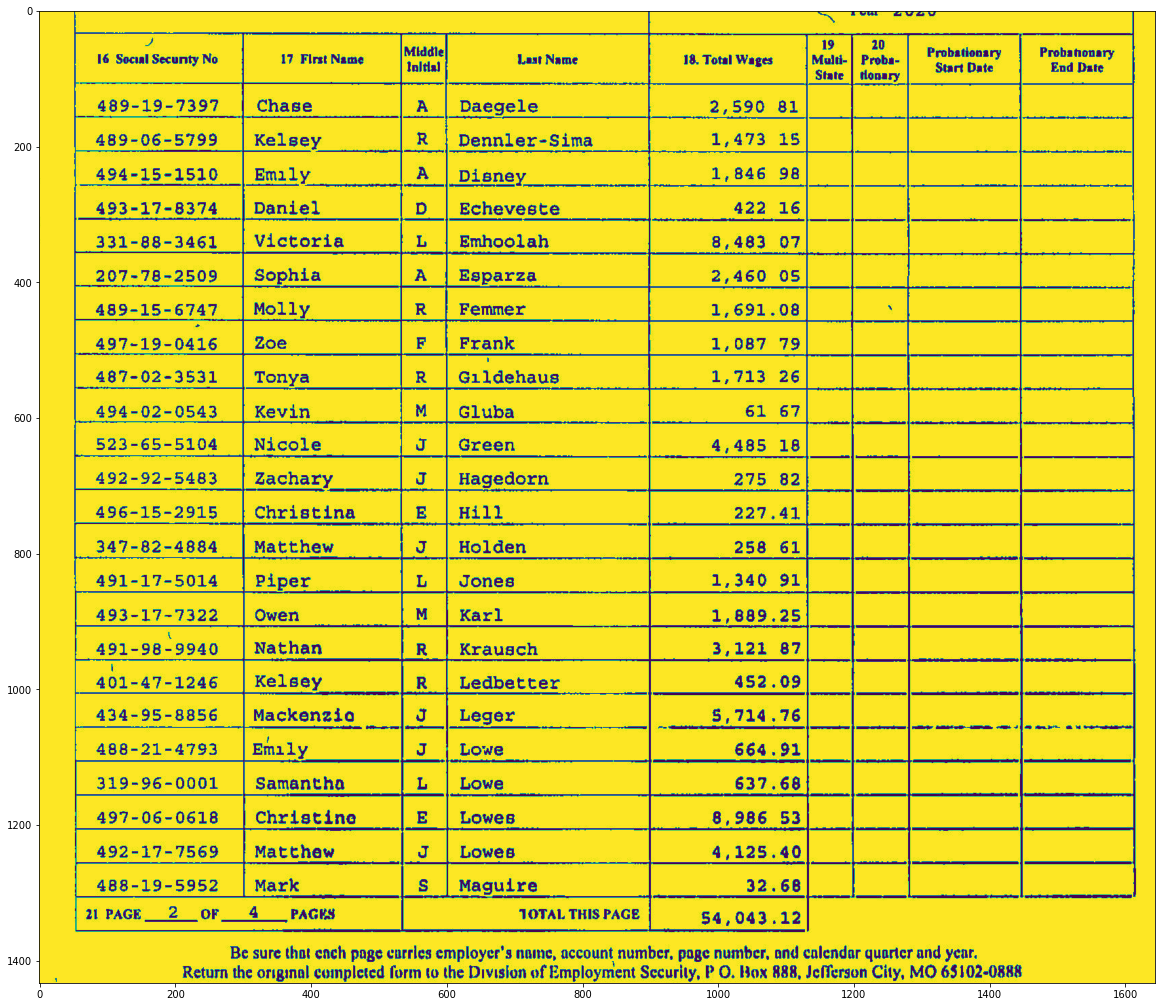

In [21]:
p = '0235032000.jpeg'

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
import math
import sys
import numpy as np
import pytesseract
import io 
import csv
import pandas as pd
import shutil, os

shutil.copytree('/home/vimal/Documents/table_detect_samples/structured images/input/sample', 
                os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                             os.path.splitext(p)[0]))
  
# Read Images
#img = mpimg.imread('/home/vimal/Documents/table_detect_samples/structured images/input/in/0836849000.jpeg')
img = mpimg.imread(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/in',p))
plt.figure(figsize=(15,15))
# Output Images
#plt.imshow(img)

# Opens a image in RGB mode
#im = Image.open(r"/home/vimal/Documents/table_detect_samples/structured images/input/in",p)
#img = mpimg.imread(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/in',p))
im = Image.open(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/in',p))

#im =cv2.imread('/home/vimal/Documents/table_detect_samples/pre/0347682000.jpeg')
# Size of the image in pixels (size of orginal image)
# (This is not mandatory)
width, height = im.size
  
# Setting the points for cropped image
left = 5
top = height /4.9
right = 1650
bottom = 3 * height / 3.5
  
# Cropped image of above dimension
# (It will not change orginal image)
im1 = im.crop((left, top, right, bottom))
plt.figure(figsize=(20,20))
plt.imshow(im1)
#im1.save('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images/0836849000_crop.jpeg')
#im1.save('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images/0836849000_crop.jpeg')
b = os.path.splitext(p)[0]+'_crop.jpeg'
im1.save(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images',b))
# Shows the image in image viewer

def extract_cell_images_from_table(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
    )
    
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.05 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    
    # Filter out contours that aren't rectangular. Those that aren't rectangular
    # are probably noise.
    approx_rects = [p for p in approx_polys if len(p) == 4]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]
    
    # Filter out rectangles that are too narrow or too short.
    MIN_RECT_WIDTH = 40
    MIN_RECT_HEIGHT = 10
    bounding_rects = [
        r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
    ]
    
    # The largest bounding rectangle is assumed to be the entire table.
    # Remove it from the list. We don't want to accidentally try to OCR
    # the entire table.
    largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
    bounding_rects = [b for b in bounding_rects if b is not largest_rect]
    
    cells = [c for c in bounding_rects]
    def cell_in_same_row(c1, c2):
        c1_center = c1[1] + c1[3] - c1[3] / 2
        c2_bottom = c2[1] + c2[3]
        c2_top = c2[1]
        return c2_top < c1_center < c2_bottom
    
    orig_cells = [c for c in cells]
    rows = []
    while cells:
        first = cells[0]
        rest = cells[1:]
        cells_in_same_row = sorted(
            [
                c for c in rest
                if cell_in_same_row(c, first)
            ],
            key=lambda c: c[0]
        )
    
        row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
        rows.append(row_cells)
        cells = [
            c for c in rest
            if not cell_in_same_row(c, first)
        ]
    
    # Sort rows by average height of their center.
    def avg_height_of_center(row):
        centers = [y + h - h / 2 for x, y, w, h in row]
        return sum(centers) / len(centers)
    
    rows.sort(key=avg_height_of_center)
    cell_images_rows = []
    for row in rows:
        cell_images_row = []
        for x, y, w, h in row:
            cell_images_row.append(image[y:y+h, x:x+w])
        cell_images_rows.append(cell_images_row)
    return cell_images_rows

def main(f):
    results = []
    directory, filename = os.path.split(f)
    table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    rows = extract_cell_images_from_table(table)
    cell_img_dir = os.path.join(directory, "cells")
    os.makedirs(cell_img_dir, exist_ok=True)
    out_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'cells')
    paths = []
    for i, row in enumerate(rows):
        for j, cell in enumerate(row):
            cell_filename = "{:03d}-{:03d}.png".format(i, j)
            path = os.path.join(out_path, cell_filename)
            cv2.imwrite(path, cell)
            paths.append(path)
    return paths

f = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images',b)

main(f)

def main(image_file, tess_args):
    """
    OCR the image and output the text to a file with an extension that is ready
    to be used in Tesseract training (.gt.txt).
    Tries to crop the image so that only the relevant text gets passed to Tesseract.
    Returns the name of the text file that contains the text.
    """
    #file_path = '/home/vimal/Documents/table_detect_samples/structured images/input/011364700/cells'
    #image_file = os.listdir(file_path)
    
    for f in image_file:
        #print(f)
        directory, filename = os.path.split(f)
        filename_sans_ext, ext = os.path.splitext(filename)
        image = cv2.imread(os.path.join(file_path,f), cv2.IMREAD_GRAYSCALE)
        cropped = crop_to_text(image)
        #ocr_data_dir = os.path.join(directory, "ocr_data")
        #os.makedirs(ocr_data_dir, exist_ok=True)
        #out_imagepath = os.path.join(ocr_data_dir, filename)
        out_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'text')
        out_txtpath = os.path.join(out_path, "{}.gt.txt".format(filename_sans_ext))
        #cv2.imwrite(out_imagepath, cropped)
        if not tess_args:
            d = os.path.dirname(sys.modules["table_ocr"].__file__)
            tessdata_dir = os.path.join(d, "tessdata")
            tess_args = ["--psm", "7", "-l", "table-ocr", "--tessdata-dir", tessdata_dir]
        txt = ocr_image(cropped, " ".join(tess_args))
        with open(out_txtpath, "w") as txt_file:
            txt_file.write(txt)
        #return out_txtpath
def crop_to_text(image):
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2

    img_bin = cv2.adaptiveThreshold(
        ~image,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )

    img_h, img_w = image.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img_w * 0.5), 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(img_h * 0.7)))
    horizontal_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    both = horizontal_lines + vertical_lines
    cleaned = img_bin - both

    # Get rid of little noise.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)
    opened = cv2.dilate(opened, kernel)

    contours, hierarchy = cv2.findContours(opened, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    bounding_rects = [cv2.boundingRect(c) for c in contours]
    NUM_PX_COMMA = 6
    MIN_CHAR_AREA = 5 * 9
    char_sized_bounding_rects = [(x, y, w, h) for x, y, w, h in bounding_rects if w * h > MIN_CHAR_AREA]
    if char_sized_bounding_rects:
        minx, miny, maxx, maxy = math.inf, math.inf, 0, 0
        for x, y, w, h in char_sized_bounding_rects:
            minx = min(minx, x)
            miny = min(miny, y)
            maxx = max(maxx, x + w)
            maxy = max(maxy, y + h)
        x, y, w, h = minx, miny, maxx - minx, maxy - miny
        cropped = image[y:min(img_h, y+h+NUM_PX_COMMA), x:min(img_w, x+w)]
    else:
        # If we morphed out all of the text, assume an empty image.
        cropped = MAX_COLOR_VAL * np.ones(shape=(20, 100), dtype=np.uint8)
    bordered = cv2.copyMakeBorder(cropped, 5, 5, 5, 5, cv2.BORDER_CONSTANT, None, 255)
    return bordered
def ocr_image(image, config):
    return pytesseract.image_to_string(
        image,
        config=config
    )

file_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'cells')
image_file = os.listdir(file_path)
tess_args = os.listdir(file_path)

main(image_file, tess_args)

def text_files_to_csv(files):
    """Files must be sorted lexicographically
    Filenames must be <row>-<colum>.txt.
    000-000.txt
    000-001.txt
    001-000.txt
    etc...
    """
    rows = []
    for f in files:
        directory, filename = os.path.split(f)
        with open(os.path.join(file_path,f)) as of:
            txt = of.read().strip()
        row, column = map(int, filename.split(".")[0].split("-"))
        if row == len(rows):
            rows.append([])
        rows[row].append(txt)

    csv_file = io.StringIO()
    writer = csv.writer(csv_file)
    writer.writerows(rows)
    return csv_file.getvalue()

def main(files):
    return text_files_to_csv(files)


file_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'text')
file = file = os.listdir(file_path)
files = sorted(file)

a = main(files)
#print(a)

c = os.path.splitext(p)[0]+'_text.txt'
cs = os.path.splitext(p)[0]+'_xl.csv'

text_file = open(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'text_file',c), "wt")
n = text_file.write(a)
text_file.close()

df = pd.read_csv(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'text_file',c),header=None)
#df = df.dropna(how='all', axis=1)
df.columns = df.iloc[0]
df = df[1:]
df.to_csv(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'csv',cs), 
                  index = None)
df





0                1         2              3        4   5
0                   NaN              NaN       NaN          Clark  4277.59 NaN
1           490-13-6106              NaN       NaN  Clinkinabeard   450.00 NaN
2           344-98-1804              NaN       NaN        Findley  3703.53 NaN
3           495-15-8717              NaN       NaN       Montford  2776.71 NaN
4           490-15-2858              NaN       NaN            NaN  4365.45 NaN
5           500-11-1259              NaN       NaN          Smith   197.70 NaN
6           487-08-6308              NaN       NaN           Tran  3750.00 NaN
7                   NaN              NaN       NaN            NaN      NaN NaN
8                   NaN              NaN       NaN            NaN      NaN NaN
9  20 PAGE 1 OF 1 PAGES  TOTAL THIS PAGE  19520.98            NaN      NaN NaN

<Figure size 1080x1080 with 0 Axes>

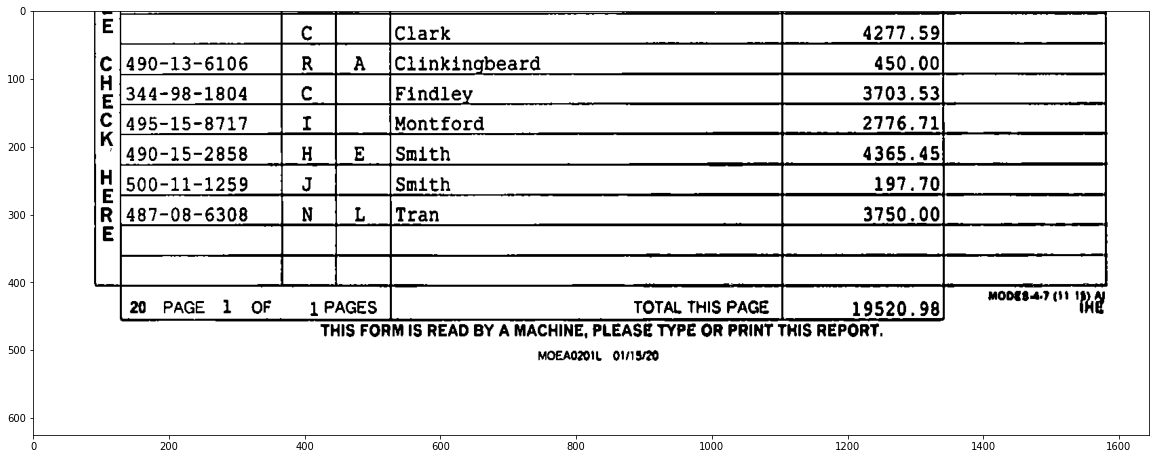

In [77]:
p = '0647318000.jpeg'

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
import math
import sys
import numpy as np
import pytesseract
import io 
import csv
import pandas as pd
import shutil, os

shutil.copytree('/home/vimal/Documents/table_detect_samples/structured images/input/sample', 
                os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                             os.path.splitext(p)[0]))
  
# Read Images
#img = mpimg.imread('/home/vimal/Documents/table_detect_samples/structured images/input/in/0836849000.jpeg')
img = mpimg.imread(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/in',p))
plt.figure(figsize=(15,15))
# Output Images
#plt.imshow(img)

# Opens a image in RGB mode
#im = Image.open(r"/home/vimal/Documents/table_detect_samples/structured images/input/in",p)
#img = mpimg.imread(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/in',p))
im = Image.open(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/in',p))

#im =cv2.imread('/home/vimal/Documents/table_detect_samples/pre/0347682000.jpeg')
# Size of the image in pixels (size of orginal image)
# (This is not mandatory)
width, height = im.size
  
# Setting the points for cropped image
left = 5
top = height / 1.4
right = 1650
bottom = 3 * height / 3
  
# Cropped image of above dimension
# (It will not change orginal image)
im1 = im.crop((left, top, right, bottom))
plt.figure(figsize=(20,20))
plt.imshow(im1)
#im1.save('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images/0836849000_crop.jpeg')
#im1.save('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images/0836849000_crop.jpeg')
b = os.path.splitext(p)[0]+'_crop.jpeg'
im1.save(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images',b))
# Shows the image in image viewer

def extract_cell_images_from_table(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
    )
    
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.05 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    
    # Filter out contours that aren't rectangular. Those that aren't rectangular
    # are probably noise.
    approx_rects = [p for p in approx_polys if len(p) == 4]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]
    
    # Filter out rectangles that are too narrow or too short.
    MIN_RECT_WIDTH = 40
    MIN_RECT_HEIGHT = 10
    bounding_rects = [
        r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
    ]
    
    # The largest bounding rectangle is assumed to be the entire table.
    # Remove it from the list. We don't want to accidentally try to OCR
    # the entire table.
    largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
    bounding_rects = [b for b in bounding_rects if b is not largest_rect]
    
    cells = [c for c in bounding_rects]
    def cell_in_same_row(c1, c2):
        c1_center = c1[1] + c1[3] - c1[3] / 2
        c2_bottom = c2[1] + c2[3]
        c2_top = c2[1]
        return c2_top < c1_center < c2_bottom
    
    orig_cells = [c for c in cells]
    rows = []
    while cells:
        first = cells[0]
        rest = cells[1:]
        cells_in_same_row = sorted(
            [
                c for c in rest
                if cell_in_same_row(c, first)
            ],
            key=lambda c: c[0]
        )
    
        row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
        rows.append(row_cells)
        cells = [
            c for c in rest
            if not cell_in_same_row(c, first)
        ]
    
    # Sort rows by average height of their center.
    def avg_height_of_center(row):
        centers = [y + h - h / 2 for x, y, w, h in row]
        return sum(centers) / len(centers)
    
    rows.sort(key=avg_height_of_center)
    cell_images_rows = []
    for row in rows:
        cell_images_row = []
        for x, y, w, h in row:
            cell_images_row.append(image[y:y+h, x:x+w])
        cell_images_rows.append(cell_images_row)
    return cell_images_rows

def main(f):
    results = []
    directory, filename = os.path.split(f)
    table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    rows = extract_cell_images_from_table(table)
    cell_img_dir = os.path.join(directory, "cells")
    os.makedirs(cell_img_dir, exist_ok=True)
    out_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'cells')
    paths = []
    for i, row in enumerate(rows):
        for j, cell in enumerate(row):
            cell_filename = "{:03d}-{:03d}.png".format(i, j)
            path = os.path.join(out_path, cell_filename)
            cv2.imwrite(path, cell)
            paths.append(path)
    return paths

f = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images',b)

main(f)

def main(image_file, tess_args):
    """
    OCR the image and output the text to a file with an extension that is ready
    to be used in Tesseract training (.gt.txt).
    Tries to crop the image so that only the relevant text gets passed to Tesseract.
    Returns the name of the text file that contains the text.
    """
    #file_path = '/home/vimal/Documents/table_detect_samples/structured images/input/011364700/cells'
    #image_file = os.listdir(file_path)
    
    for f in image_file:
        #print(f)
        directory, filename = os.path.split(f)
        filename_sans_ext, ext = os.path.splitext(filename)
        image = cv2.imread(os.path.join(file_path,f), cv2.IMREAD_GRAYSCALE)
        cropped = crop_to_text(image)
        #ocr_data_dir = os.path.join(directory, "ocr_data")
        #os.makedirs(ocr_data_dir, exist_ok=True)
        #out_imagepath = os.path.join(ocr_data_dir, filename)
        out_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'text')
        out_txtpath = os.path.join(out_path, "{}.gt.txt".format(filename_sans_ext))
        #cv2.imwrite(out_imagepath, cropped)
        if not tess_args:
            d = os.path.dirname(sys.modules["table_ocr"].__file__)
            tessdata_dir = os.path.join(d, "tessdata")
            tess_args = ["--psm", "7", "-l", "table-ocr", "--tessdata-dir", tessdata_dir]
        txt = ocr_image(cropped, " ".join(tess_args))
        with open(out_txtpath, "w") as txt_file:
            txt_file.write(txt)
        #return out_txtpath
def crop_to_text(image):
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2

    img_bin = cv2.adaptiveThreshold(
        ~image,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )

    img_h, img_w = image.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img_w * 0.5), 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(img_h * 0.7)))
    horizontal_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    both = horizontal_lines + vertical_lines
    cleaned = img_bin - both

    # Get rid of little noise.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)
    opened = cv2.dilate(opened, kernel)

    contours, hierarchy = cv2.findContours(opened, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    bounding_rects = [cv2.boundingRect(c) for c in contours]
    NUM_PX_COMMA = 6
    MIN_CHAR_AREA = 5 * 9
    char_sized_bounding_rects = [(x, y, w, h) for x, y, w, h in bounding_rects if w * h > MIN_CHAR_AREA]
    if char_sized_bounding_rects:
        minx, miny, maxx, maxy = math.inf, math.inf, 0, 0
        for x, y, w, h in char_sized_bounding_rects:
            minx = min(minx, x)
            miny = min(miny, y)
            maxx = max(maxx, x + w)
            maxy = max(maxy, y + h)
        x, y, w, h = minx, miny, maxx - minx, maxy - miny
        cropped = image[y:min(img_h, y+h+NUM_PX_COMMA), x:min(img_w, x+w)]
    else:
        # If we morphed out all of the text, assume an empty image.
        cropped = MAX_COLOR_VAL * np.ones(shape=(20, 100), dtype=np.uint8)
    bordered = cv2.copyMakeBorder(cropped, 5, 5, 5, 5, cv2.BORDER_CONSTANT, None, 255)
    return bordered
def ocr_image(image, config):
    return pytesseract.image_to_string(
        image,
        config=config
    )

file_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'cells')
image_file = os.listdir(file_path)
tess_args = os.listdir(file_path)

main(image_file, tess_args)

def text_files_to_csv(files):
    """Files must be sorted lexicographically
    Filenames must be <row>-<colum>.txt.
    000-000.txt
    000-001.txt
    001-000.txt
    etc...
    """
    rows = []
    for f in files:
        directory, filename = os.path.split(f)
        with open(os.path.join(file_path,f)) as of:
            txt = of.read().strip()
        row, column = map(int, filename.split(".")[0].split("-"))
        if row == len(rows):
            rows.append([])
        rows[row].append(txt)

    csv_file = io.StringIO()
    writer = csv.writer(csv_file)
    writer.writerows(rows)
    return csv_file.getvalue()

def main(files):
    return text_files_to_csv(files)


file_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'text')
file = file = os.listdir(file_path)
files = sorted(file)

a = main(files)
#print(a)

c = os.path.splitext(p)[0]+'_text.txt'
cs = os.path.splitext(p)[0]+'_xl.csv'

text_file = open(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'text_file',c), "wt")
n = text_file.write(a)
text_file.close()

df = pd.read_csv(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'text_file',c),header=None)
#df = df.dropna(how='all', axis=1)
#df.columns = df.iloc[0]
#df = df[1:]
df.to_csv(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'csv',cs), 
                  index = None)
df





0                1         2              3        4   5
0                   NaN              NaN       NaN          Clark  4277.59 NaN
1           490-13-6106              NaN       NaN  Clinkinabeard   450.00 NaN
2           344-98-1804              NaN       NaN        Findley  3703.53 NaN
3           495-15-8717              NaN       NaN       Montford  2776.71 NaN
4           490-15-2858              NaN       NaN            NaN  4365.45 NaN
5           500-11-1259              NaN       NaN          Smith   197.70 NaN
6           487-08-6308              NaN       NaN           Tran  3750.00 NaN
7                   NaN              NaN       NaN            NaN      NaN NaN
8                   NaN              NaN       NaN            NaN      NaN NaN
9  20 PAGE 1 OF 1 PAGES  TOTAL THIS PAGE  19520.98            NaN      NaN NaN

<Figure size 1080x1080 with 0 Axes>

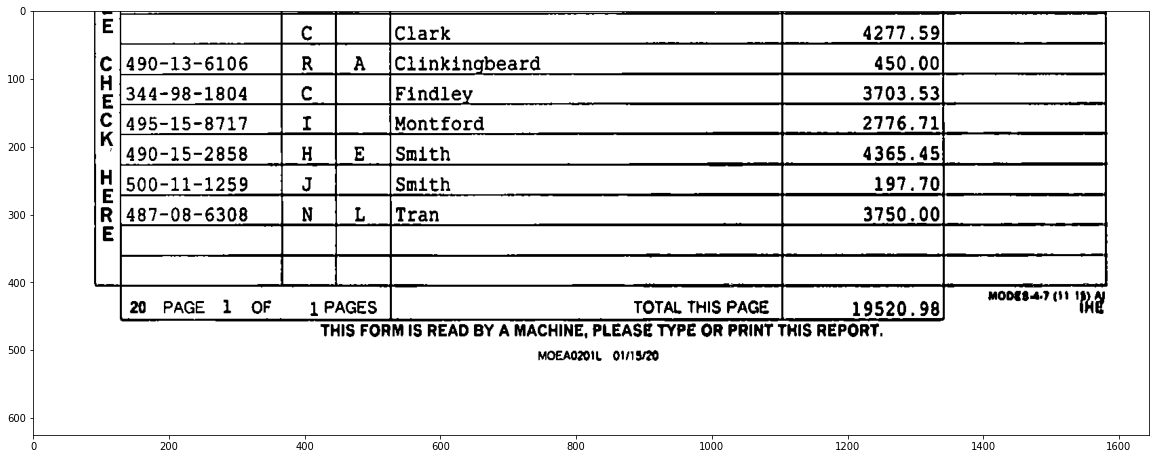

In [76]:
p = '0647318000.jpeg'

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
import math
import sys
import numpy as np
import pytesseract
import io 
import csv
import pandas as pd
import shutil, os

shutil.copytree('/home/vimal/Documents/table_detect_samples/structured images/input/sample', 
                os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                             os.path.splitext(p)[0]))
  
# Read Images
#img = mpimg.imread('/home/vimal/Documents/table_detect_samples/structured images/input/in/0836849000.jpeg')
img = mpimg.imread(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/in',p))
plt.figure(figsize=(15,15))
# Output Images
#plt.imshow(img)

# Opens a image in RGB mode
#im = Image.open(r"/home/vimal/Documents/table_detect_samples/structured images/input/in",p)
#img = mpimg.imread(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/in',p))
im = Image.open(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/in',p))

#im =cv2.imread('/home/vimal/Documents/table_detect_samples/pre/0347682000.jpeg')
# Size of the image in pixels (size of orginal image)
# (This is not mandatory)
width, height = im.size
  
# Setting the points for cropped image
left = 5
top = height / 1.4
right = 1650
bottom = 3 * height / 3
  
# Cropped image of above dimension
# (It will not change orginal image)
im1 = im.crop((left, top, right, bottom))
plt.figure(figsize=(20,20))
plt.imshow(im1)
#im1.save('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images/0836849000_crop.jpeg')
#im1.save('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images/0836849000_crop.jpeg')
b = os.path.splitext(p)[0]+'_crop.jpeg'
im1.save(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images',b))
# Shows the image in image viewer

def extract_cell_images_from_table(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
    )
    
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.05 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    
    # Filter out contours that aren't rectangular. Those that aren't rectangular
    # are probably noise.
    approx_rects = [p for p in approx_polys if len(p) == 4]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]
    
    # Filter out rectangles that are too narrow or too short.
    MIN_RECT_WIDTH = 40
    MIN_RECT_HEIGHT = 10
    bounding_rects = [
        r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
    ]
    
    # The largest bounding rectangle is assumed to be the entire table.
    # Remove it from the list. We don't want to accidentally try to OCR
    # the entire table.
    largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
    bounding_rects = [b for b in bounding_rects if b is not largest_rect]
    
    cells = [c for c in bounding_rects]
    def cell_in_same_row(c1, c2):
        c1_center = c1[1] + c1[3] - c1[3] / 2
        c2_bottom = c2[1] + c2[3]
        c2_top = c2[1]
        return c2_top < c1_center < c2_bottom
    
    orig_cells = [c for c in cells]
    rows = []
    while cells:
        first = cells[0]
        rest = cells[1:]
        cells_in_same_row = sorted(
            [
                c for c in rest
                if cell_in_same_row(c, first)
            ],
            key=lambda c: c[0]
        )
    
        row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
        rows.append(row_cells)
        cells = [
            c for c in rest
            if not cell_in_same_row(c, first)
        ]
    
    # Sort rows by average height of their center.
    def avg_height_of_center(row):
        centers = [y + h - h / 2 for x, y, w, h in row]
        return sum(centers) / len(centers)
    
    rows.sort(key=avg_height_of_center)
    cell_images_rows = []
    for row in rows:
        cell_images_row = []
        for x, y, w, h in row:
            cell_images_row.append(image[y:y+h, x:x+w])
        cell_images_rows.append(cell_images_row)
    return cell_images_rows

def main(f):
    results = []
    directory, filename = os.path.split(f)
    table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    rows = extract_cell_images_from_table(table)
    cell_img_dir = os.path.join(directory, "cells")
    os.makedirs(cell_img_dir, exist_ok=True)
    out_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'cells')
    paths = []
    for i, row in enumerate(rows):
        for j, cell in enumerate(row):
            cell_filename = "{:03d}-{:03d}.png".format(i, j)
            path = os.path.join(out_path, cell_filename)
            cv2.imwrite(path, cell)
            paths.append(path)
    return paths

f = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input/crop_images',b)

main(f)

def main(image_file, tess_args):
    """
    OCR the image and output the text to a file with an extension that is ready
    to be used in Tesseract training (.gt.txt).
    Tries to crop the image so that only the relevant text gets passed to Tesseract.
    Returns the name of the text file that contains the text.
    """
    #file_path = '/home/vimal/Documents/table_detect_samples/structured images/input/011364700/cells'
    #image_file = os.listdir(file_path)
    
    for f in image_file:
        #print(f)
        directory, filename = os.path.split(f)
        filename_sans_ext, ext = os.path.splitext(filename)
        image = cv2.imread(os.path.join(file_path,f), cv2.IMREAD_GRAYSCALE)
        cropped = crop_to_text(image)
        #ocr_data_dir = os.path.join(directory, "ocr_data")
        #os.makedirs(ocr_data_dir, exist_ok=True)
        #out_imagepath = os.path.join(ocr_data_dir, filename)
        out_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'text')
        out_txtpath = os.path.join(out_path, "{}.gt.txt".format(filename_sans_ext))
        #cv2.imwrite(out_imagepath, cropped)
        if not tess_args:
            d = os.path.dirname(sys.modules["table_ocr"].__file__)
            tessdata_dir = os.path.join(d, "tessdata")
            tess_args = ["--psm", "7", "-l", "table-ocr", "--tessdata-dir", tessdata_dir]
        txt = ocr_image(cropped, " ".join(tess_args))
        with open(out_txtpath, "w") as txt_file:
            txt_file.write(txt)
        #return out_txtpath
def crop_to_text(image):
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2

    img_bin = cv2.adaptiveThreshold(
        ~image,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )

    img_h, img_w = image.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img_w * 0.5), 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(img_h * 0.7)))
    horizontal_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    both = horizontal_lines + vertical_lines
    cleaned = img_bin - both

    # Get rid of little noise.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)
    opened = cv2.dilate(opened, kernel)

    contours, hierarchy = cv2.findContours(opened, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    bounding_rects = [cv2.boundingRect(c) for c in contours]
    NUM_PX_COMMA = 6
    MIN_CHAR_AREA = 5 * 9
    char_sized_bounding_rects = [(x, y, w, h) for x, y, w, h in bounding_rects if w * h > MIN_CHAR_AREA]
    if char_sized_bounding_rects:
        minx, miny, maxx, maxy = math.inf, math.inf, 0, 0
        for x, y, w, h in char_sized_bounding_rects:
            minx = min(minx, x)
            miny = min(miny, y)
            maxx = max(maxx, x + w)
            maxy = max(maxy, y + h)
        x, y, w, h = minx, miny, maxx - minx, maxy - miny
        cropped = image[y:min(img_h, y+h+NUM_PX_COMMA), x:min(img_w, x+w)]
    else:
        # If we morphed out all of the text, assume an empty image.
        cropped = MAX_COLOR_VAL * np.ones(shape=(20, 100), dtype=np.uint8)
    bordered = cv2.copyMakeBorder(cropped, 5, 5, 5, 5, cv2.BORDER_CONSTANT, None, 255)
    return bordered
def ocr_image(image, config):
    return pytesseract.image_to_string(
        image,
        config=config
    )

file_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'cells')
image_file = os.listdir(file_path)
tess_args = os.listdir(file_path)

main(image_file, tess_args)

def text_files_to_csv(files):
    """Files must be sorted lexicographically
    Filenames must be <row>-<colum>.txt.
    000-000.txt
    000-001.txt
    001-000.txt
    etc...
    """
    rows = []
    for f in files:
        directory, filename = os.path.split(f)
        with open(os.path.join(file_path,f)) as of:
            txt = of.read().strip()
        row, column = map(int, filename.split(".")[0].split("-"))
        if row == len(rows):
            rows.append([])
        rows[row].append(txt)

    csv_file = io.StringIO()
    writer = csv.writer(csv_file)
    writer.writerows(rows)
    return csv_file.getvalue()

def main(files):
    return text_files_to_csv(files)


file_path = os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'text')
file = file = os.listdir(file_path)
files = sorted(file)

a = main(files)
#print(a)

c = os.path.splitext(p)[0]+'_text.txt'
cs = os.path.splitext(p)[0]+'_xl.csv'

text_file = open(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'text_file',c), "wt")
n = text_file.write(a)
text_file.close()

df = pd.read_csv(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'text_file',c),header=None)
#df = df.dropna(how='all', axis=1)
#df.columns = df.iloc[0]
#df = df[1:]
df.to_csv(os.path.join('/home/vimal/Documents/table_detect_samples/structured images/input',
                            os.path.splitext(p)[0],'csv',cs), 
                  index = None)
df



